<a href="https://colab.research.google.com/github/fdzcampos/ecg_ecm_classification/blob/master/ECG_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
import time

import glob
import csv 

import numpy as np
import pandas as pd

from scipy.signal import butter, filtfilt               # denoising
from scipy.signal import find_peaks

from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline # smooth lines

from mlxtend import evaluate, plotting # multiclass conf matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.preprocessing import normalize

from tensorflow.keras.utils import to_categorical

%matplotlib inline

In [2]:
path = '/content/drive/MyDrive/tfm_ECG_INES_FernandezCampos/'

plt.rcParams["figure.figsize"] = (30,6)

# Dataset

Two approaches were implemented

1.   Access [physionet](https://physionet.org/content/mitdb/1.0.0/) data directly and try to convert the .dat files into csvs
2.   Downloaded already converted ECG data from [kaggle](https://www.kaggle.com/mondejar/mitbih-database?select=100annotations.txt) and uploaded it into colab


## Physionet

In [ ]:
import wfdb # WaveForm-Database: library for reading, writing, and processing WFDB signals and annotations

In [ ]:
from google.colab import auth

auth.authenticate_user()

In [ ]:
!pip install wfdb

!curl https://sdk.cloud.google.com | bash

In [ ]:
#sdk init
# project_id = 'tfmdataset'
!gcloud init

In [ ]:
# access the data using Google Cloud
!gsutil -m cp -r gs://mitdb-1.0.0.physionet.org .

Don't know why the file isn't found by *rdsamp()*, there shouldn't be a 'content' folder in path.

In [ ]:
dat_files = glob.glob('mitdb-1.0.0.physionet.org/*.dat') # list of all .dat files in current folder
df = pd.DataFrame(data=dat_files)

df.to_csv("files_list.csv", index=False, header=None) # write list to CSV file
files = pd.read_csv("files_list.csv", header=None)

for i in range(1,len(files)+1):
    fullfilename = str(files.iloc[[i]])
    shortfilename = fullfilename[-7:-4] # just the filename (the number)
    print(fullfilename[:-4])
    
    record = wfdb.rdsamp(shortfilename) # returns signal as a np array
    record = np.asarray(record[0])
    path = shortfilename+".csv"
    np.savetxt(path, record, delimiter=",") # write CSV for each record
    print("Files done: %s/%s"% (i, len(files)))

print("\nAll files done!")	

## Kaggle dataset


In [3]:
import os
from google.colab import drive

### Load from drive

In [4]:
drive.mount('/content/drive')

os.chdir('/content/drive/My Drive/tfm_ECG_INES_FernandezCampos/mit-bih-arrhythmia-database-1.0.0_csv_kaggle/mitbih_database')

Mounted at /content/drive


In [5]:
files = glob.glob('*.csv') # list of all .csv files in current folder
annot = glob.glob('*.txt') # list of all annotations

nfiles = len(files)
nannot = len(annot)

print('nfiles:', nfiles)
print('nannot:', nannot)

nfiles: 48
nannot: 48


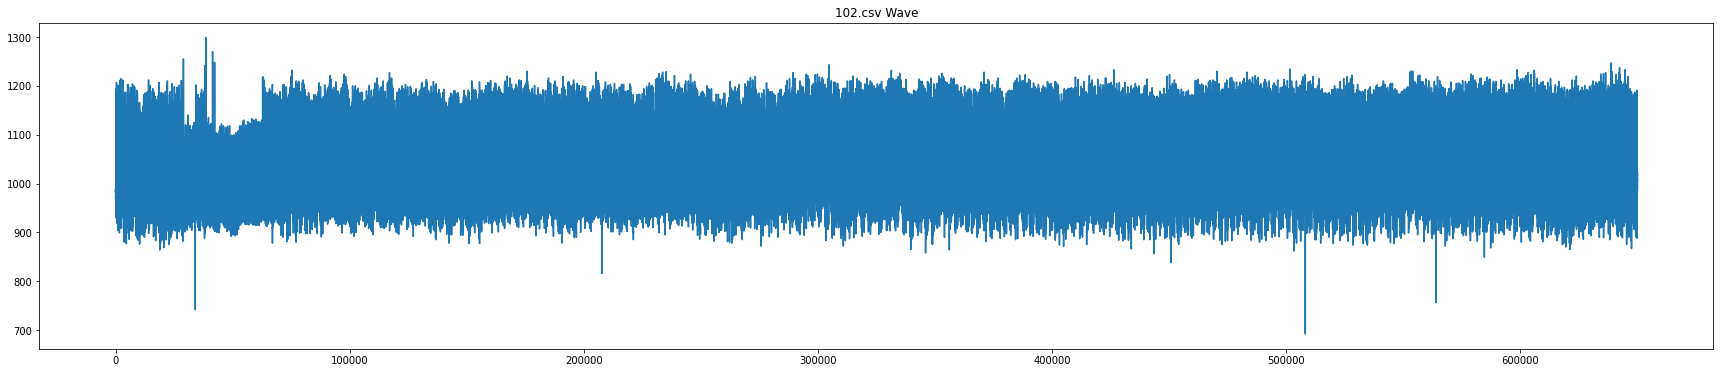

In [ ]:
# showing a record
j = 2
signals = []

with open(files[j], 'rt') as csvfile:
    csvreader = csv.reader(csvfile, delimiter=',') # read csv
    row_index = -1
    for row in csvreader:
        if(row_index >= 0):
            signals.insert(row_index, int(row[1]))
        row_index += 1

plt.title(files[j] + " Wave")
plt.plot(signals)
plt.show()

### Análisis por electrodo

Go through some signals and see what electrode seems to be clearer in order to choose what electrode to process later on.

In [ ]:
flag = True # we assume all records to have 2 electrodes signals to choose from
popular = list() # see which electrodes are used the most

for i in range(0,nfiles):
    f = pd.read_csv(files[i], index_col=0)
    cols = list(f.columns)
    for c in range(0, len(cols)): popular.append(cols[c])
    if len(cols) < 2: 
        flag = False
        print('File %d has %d electrodes'%(i, len(cols)))

if flag == True: print('All files have 2 electrode signals to choose from!')

All files have 2 electrode signals to choose from!


See what the most popular electrodes are

In [ ]:
popular = {x: popular.count(x) for x in popular}
popular = dict(sorted(popular.items(), key=lambda item: item[1], reverse=True))
popular

{"'MLII'": 46, "'V1'": 40, "'V2'": 4, "'V4'": 1, "'V5'": 5}

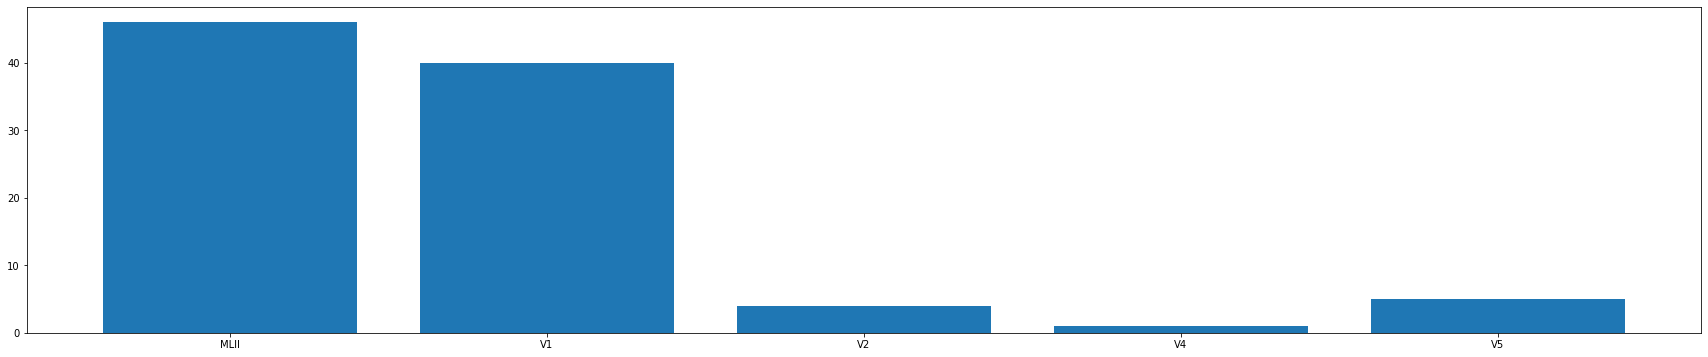

In [ ]:
D = {'MLII': 46, 'V1': 40, 'V2': 4, 'V4': 1, 'V5': 5}
plt.bar(*zip(*D.items()))
plt.show()

In [ ]:
plt.rcParams["figure.figsize"] = (50,6)

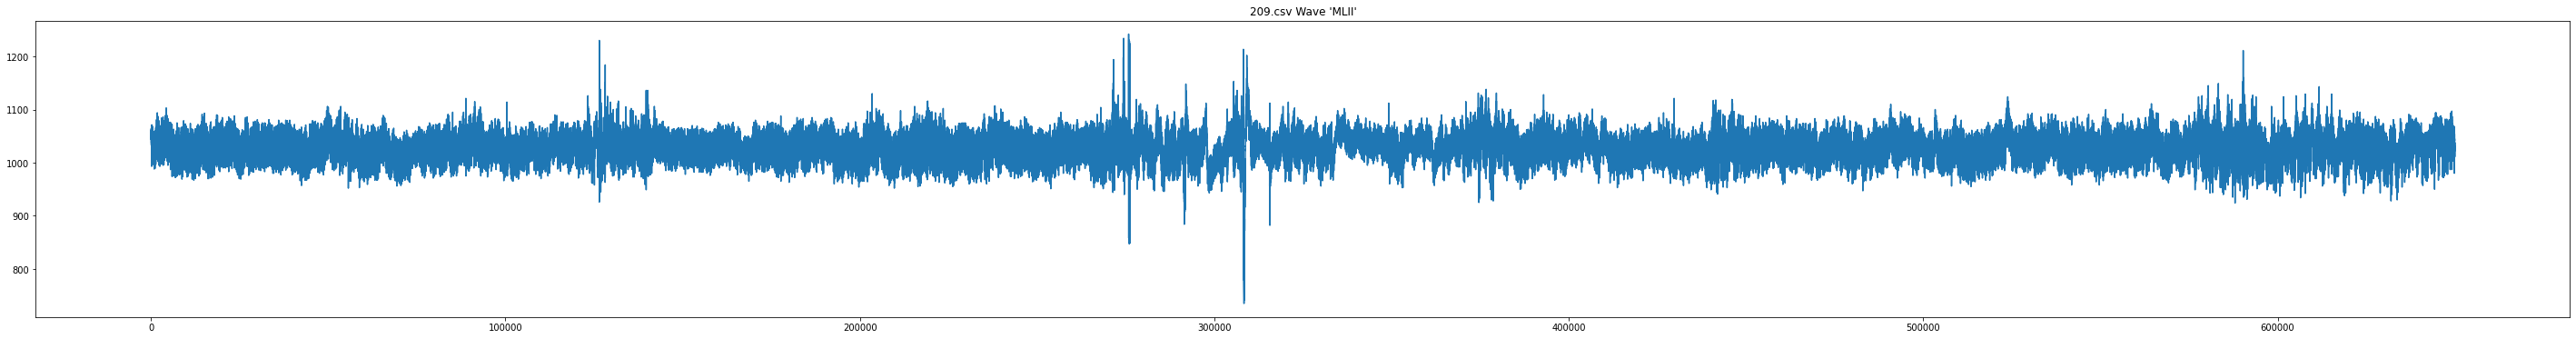

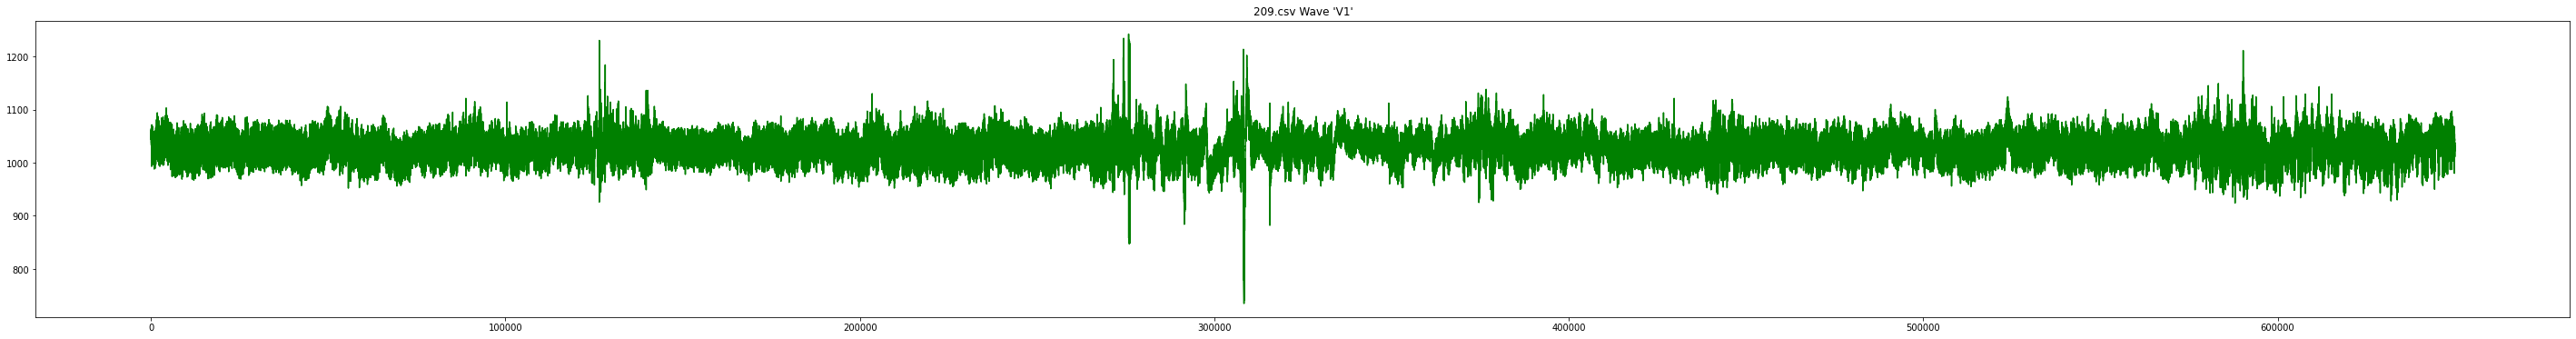

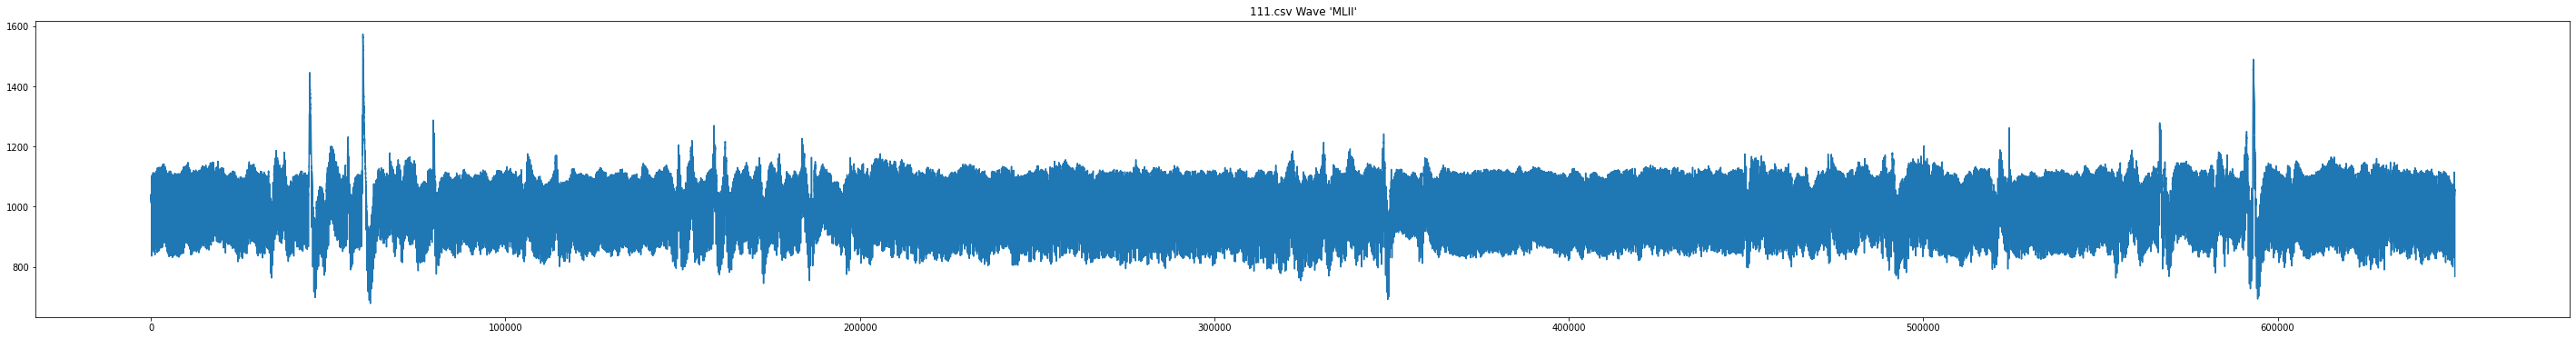

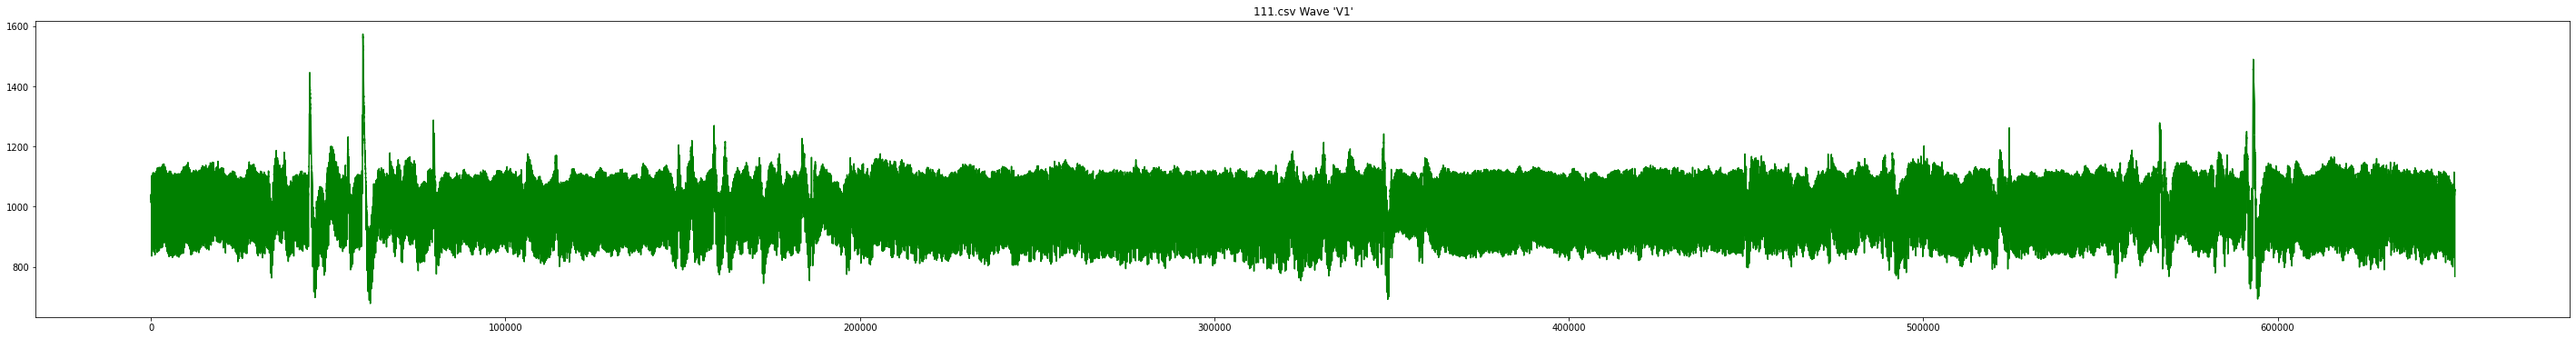

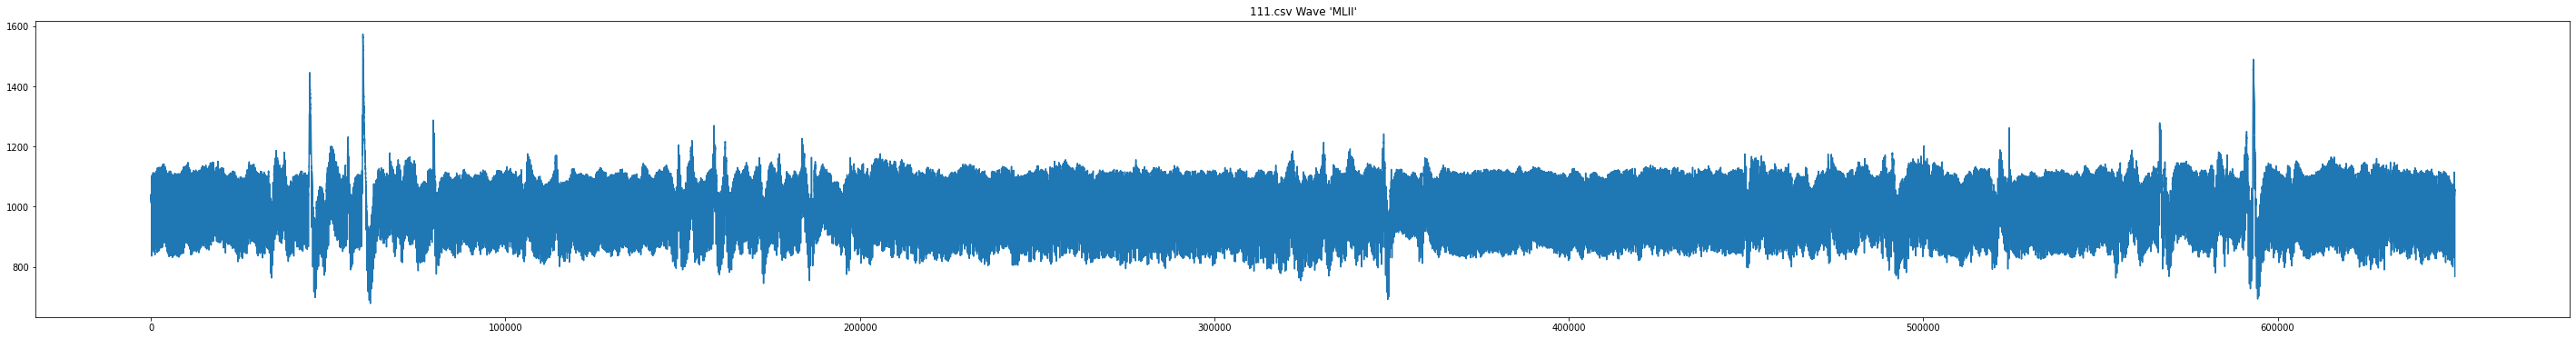

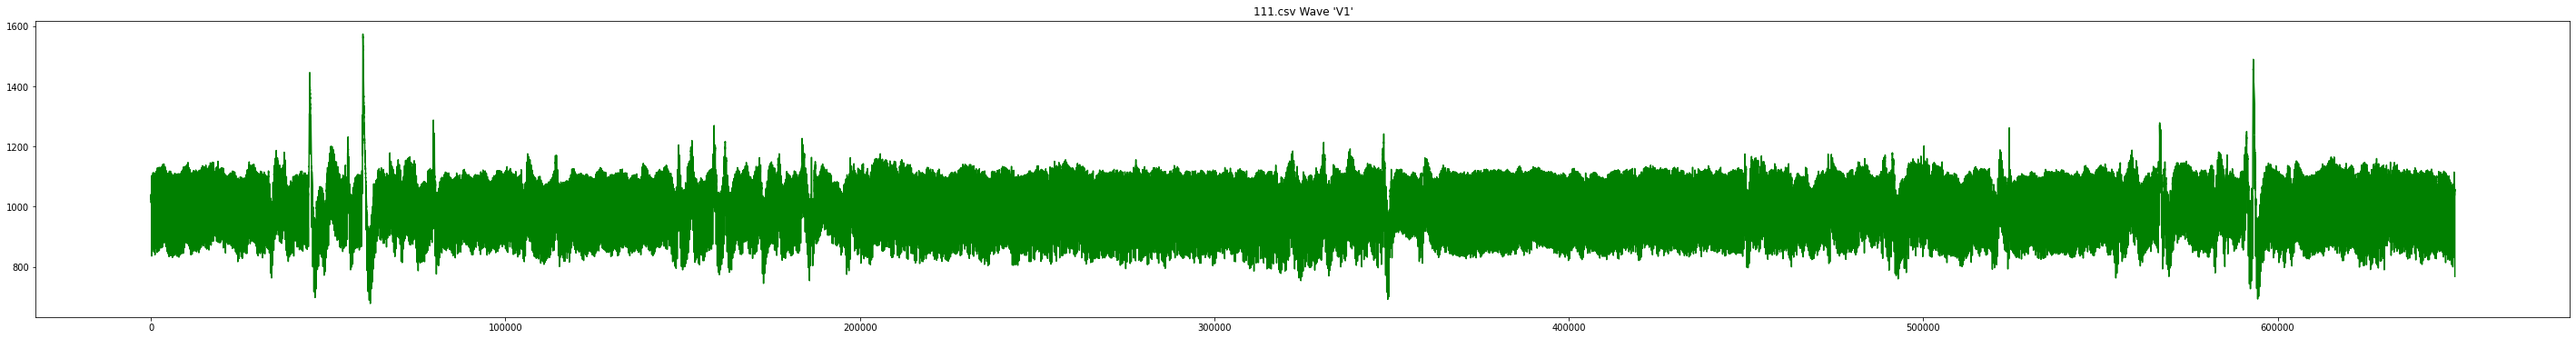

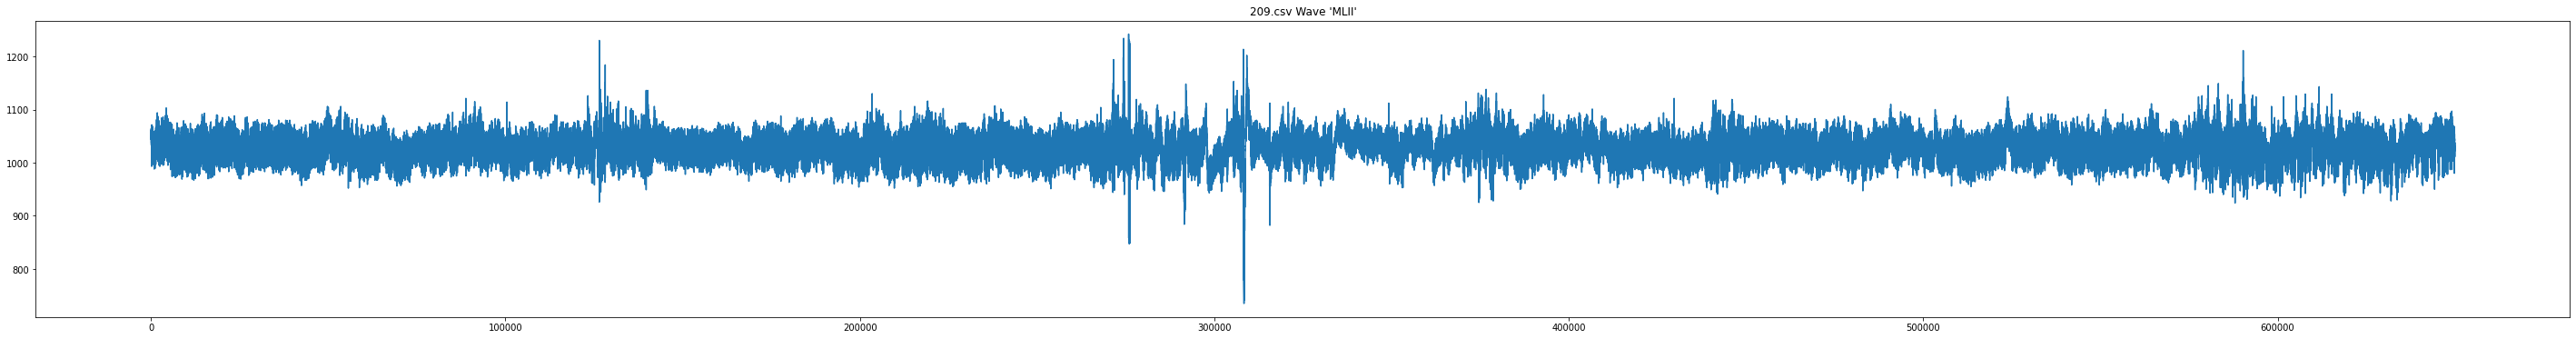

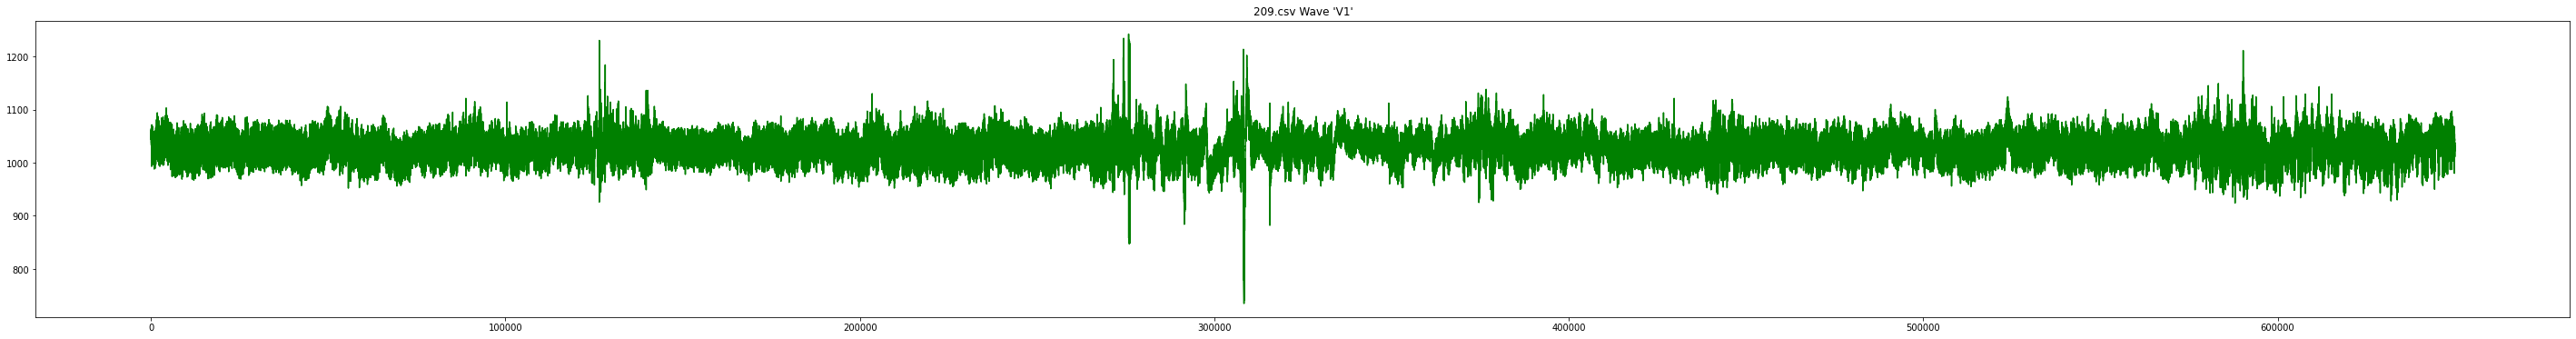

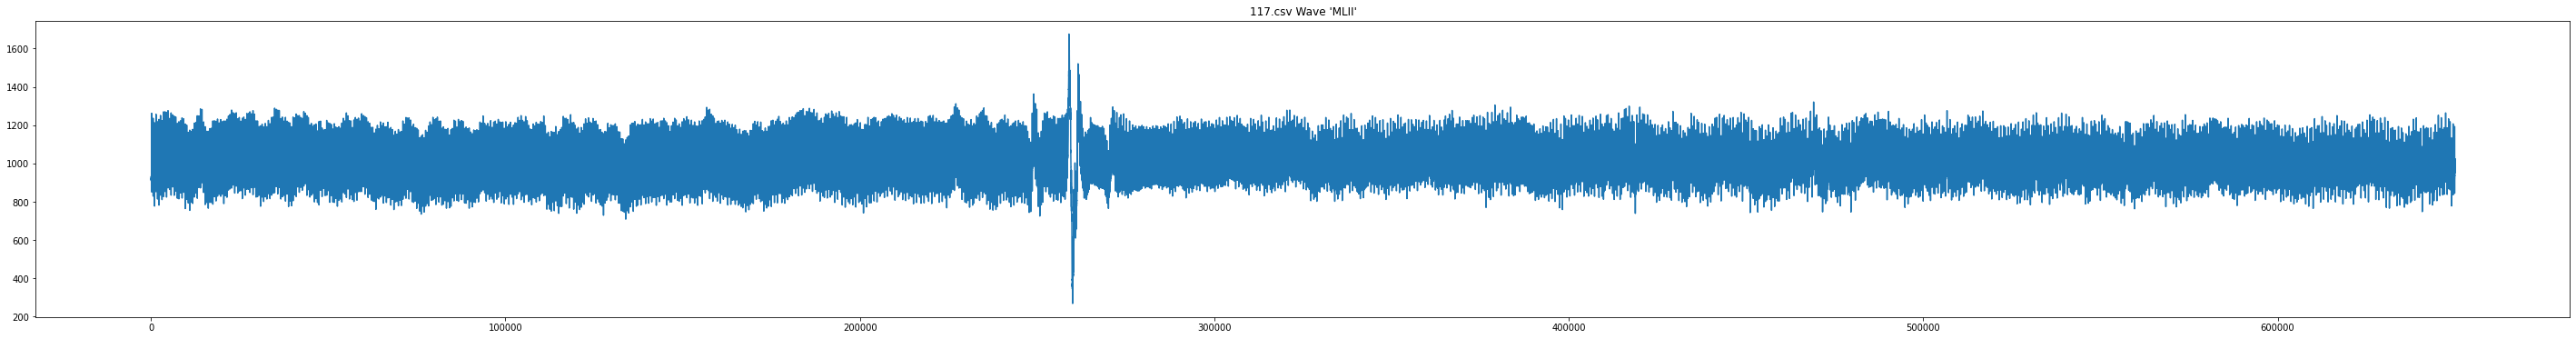

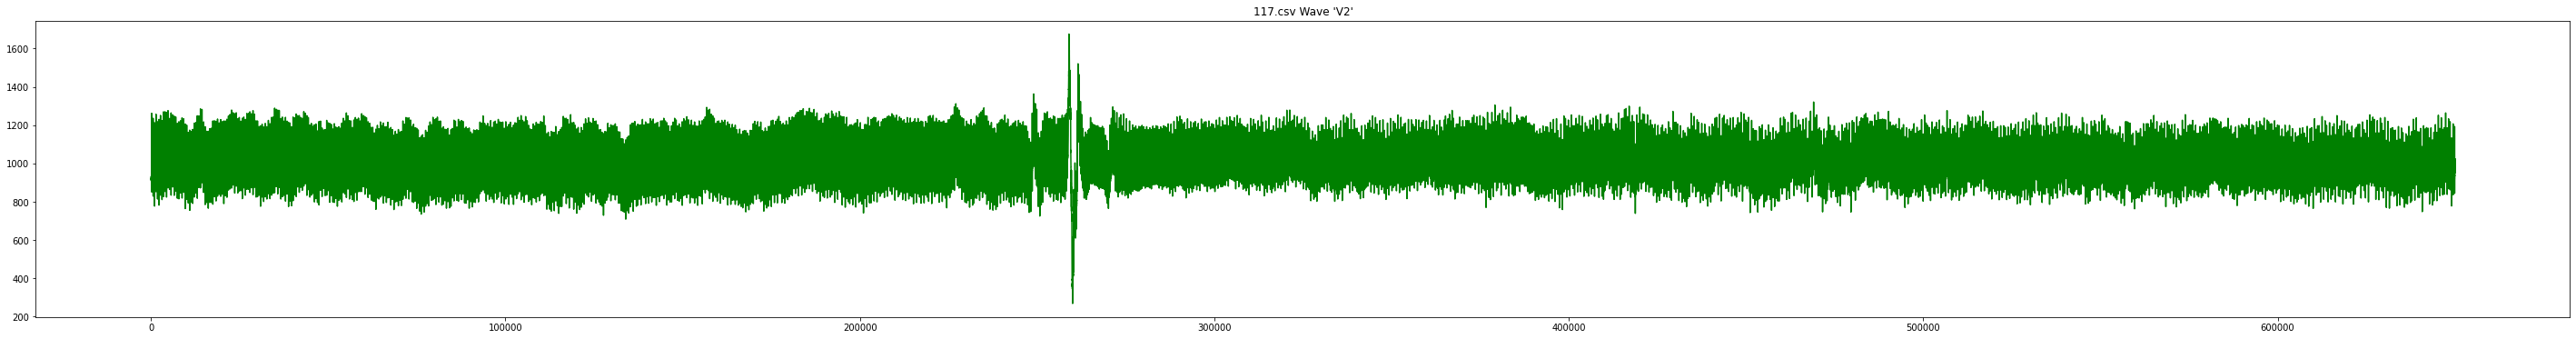

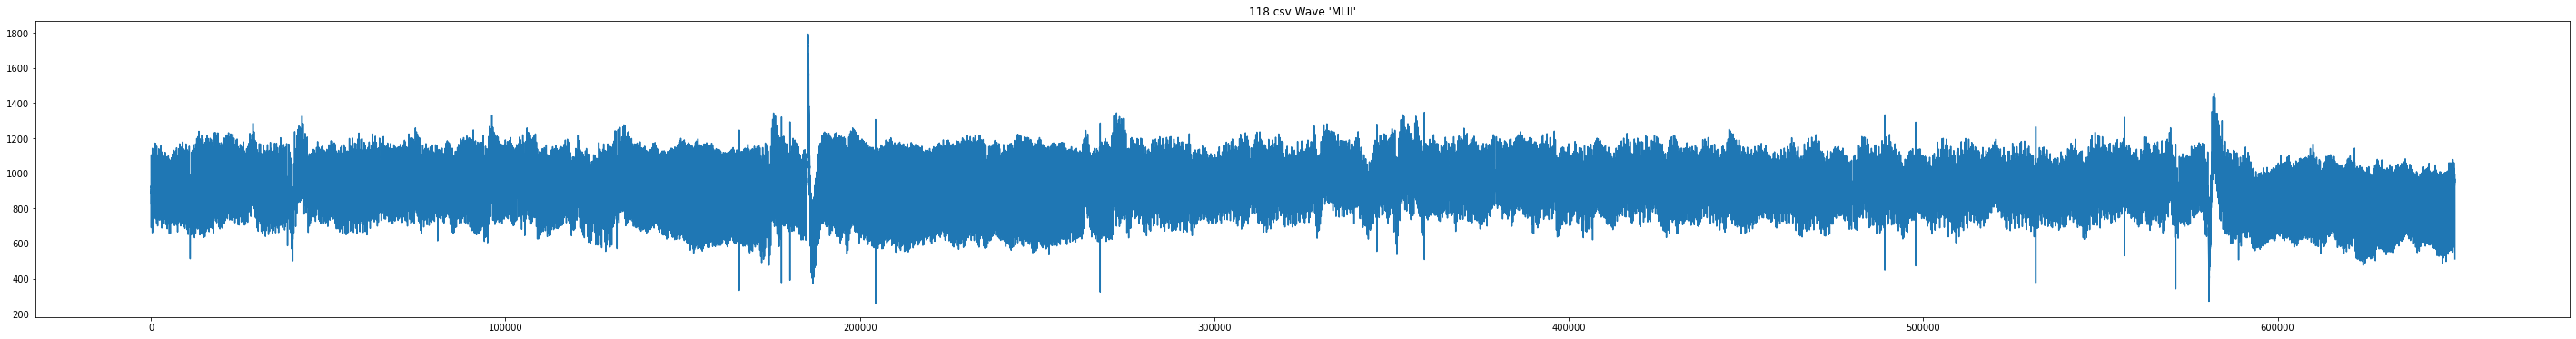

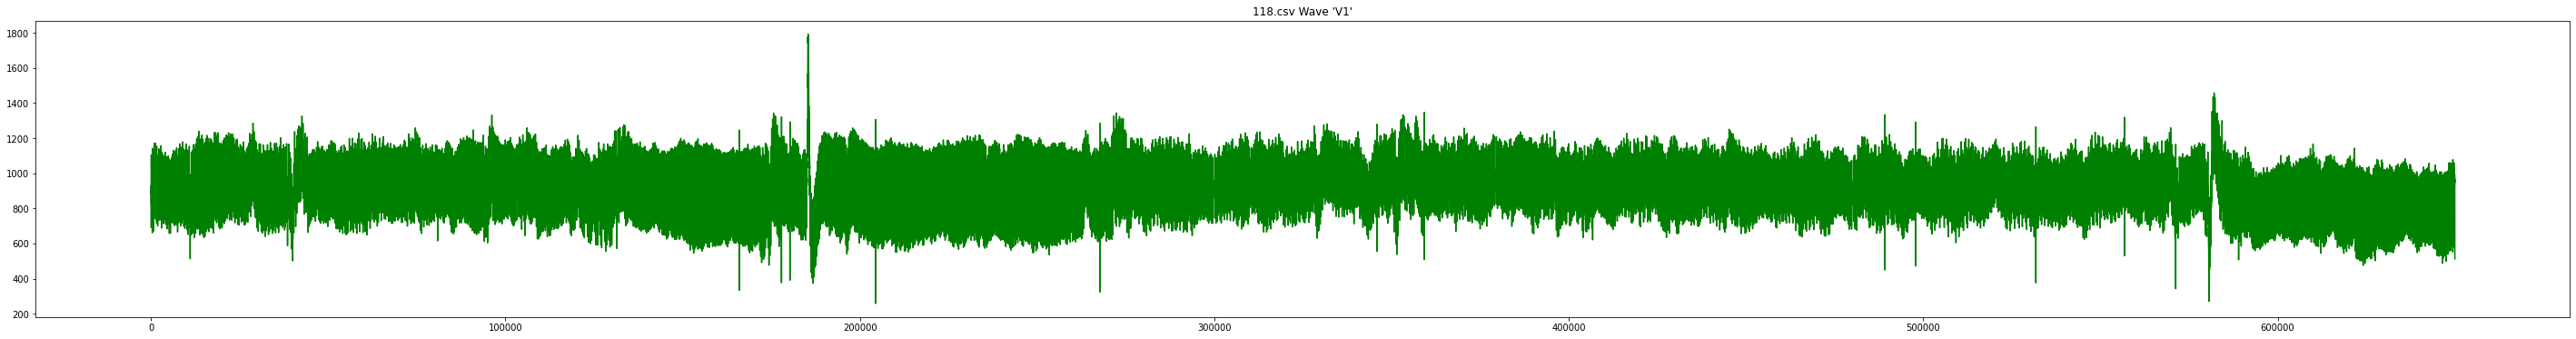

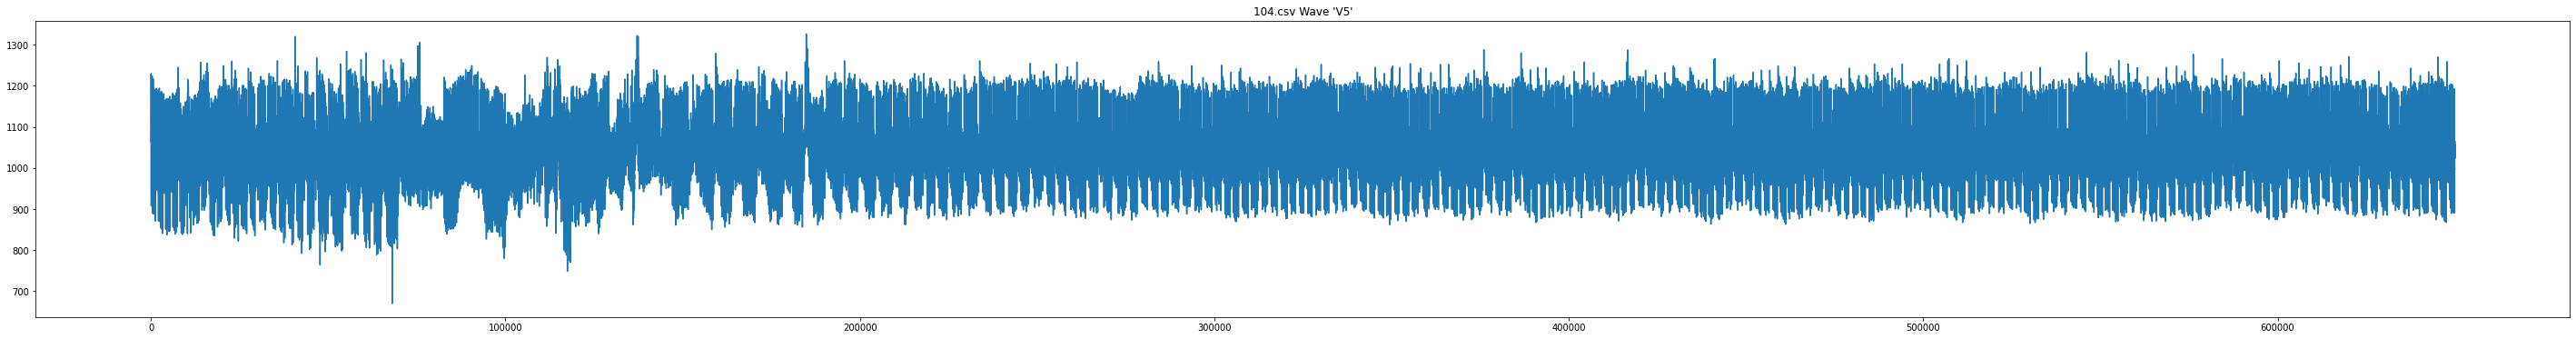

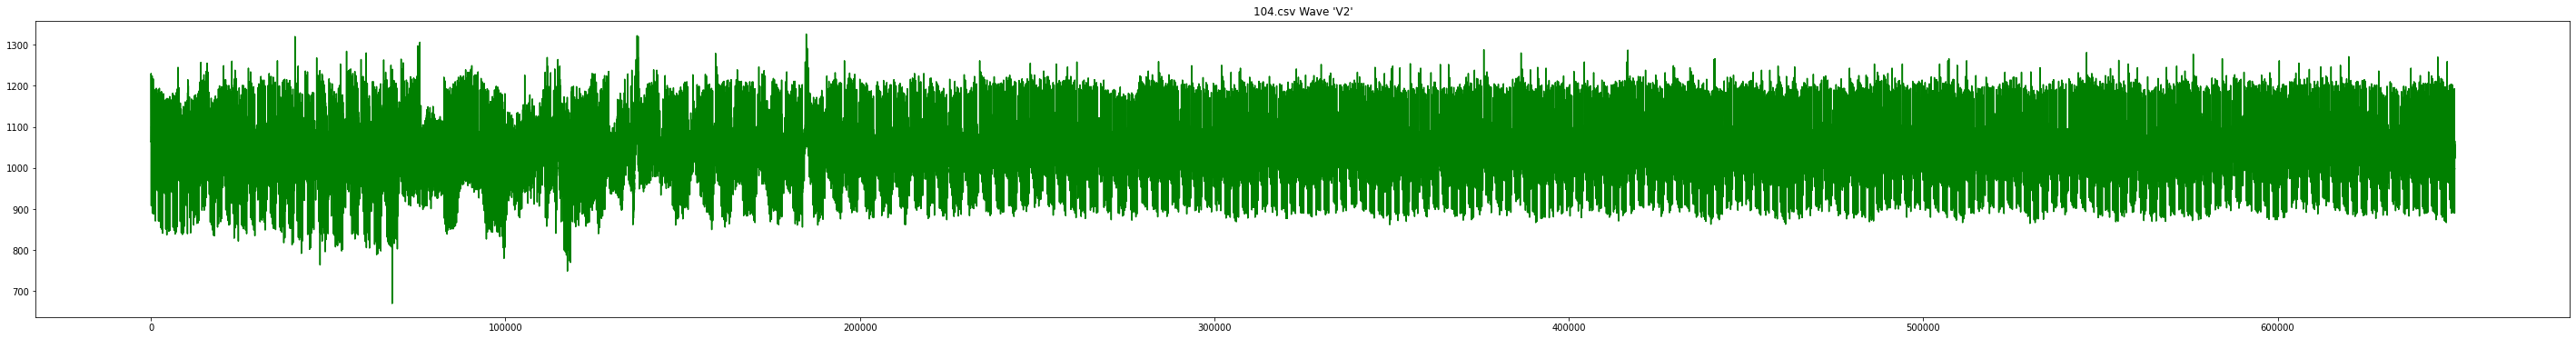

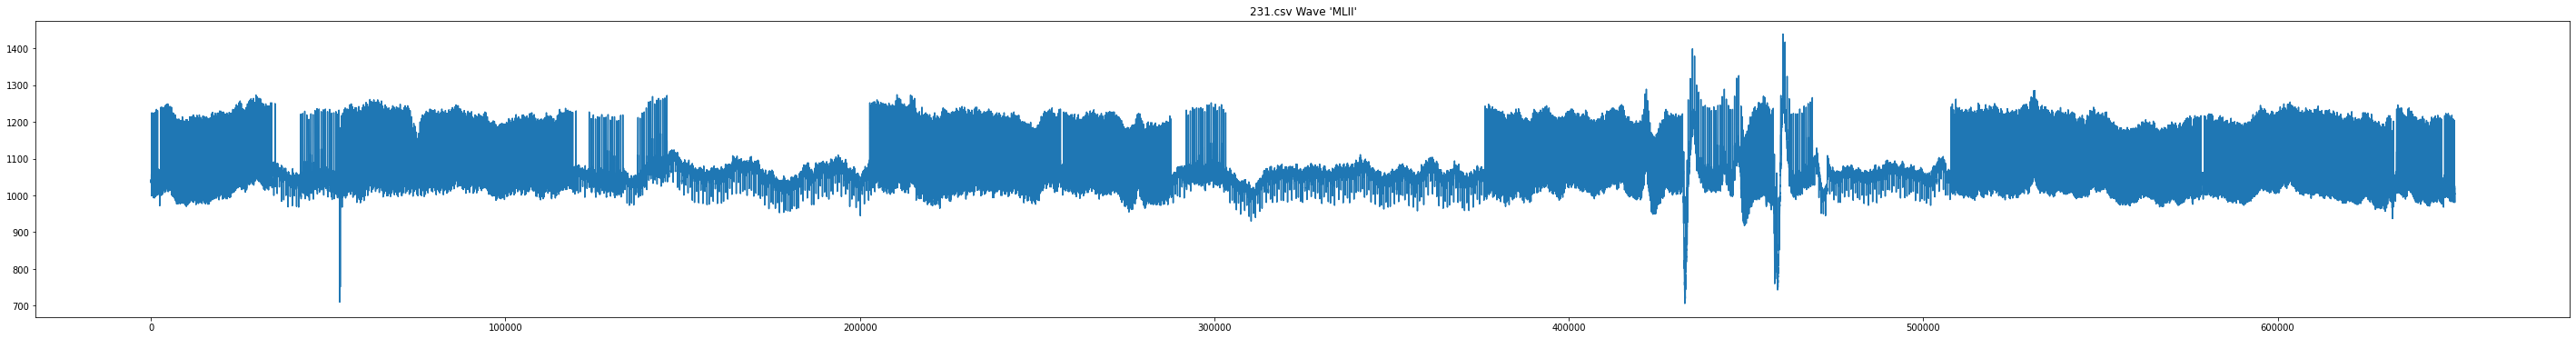

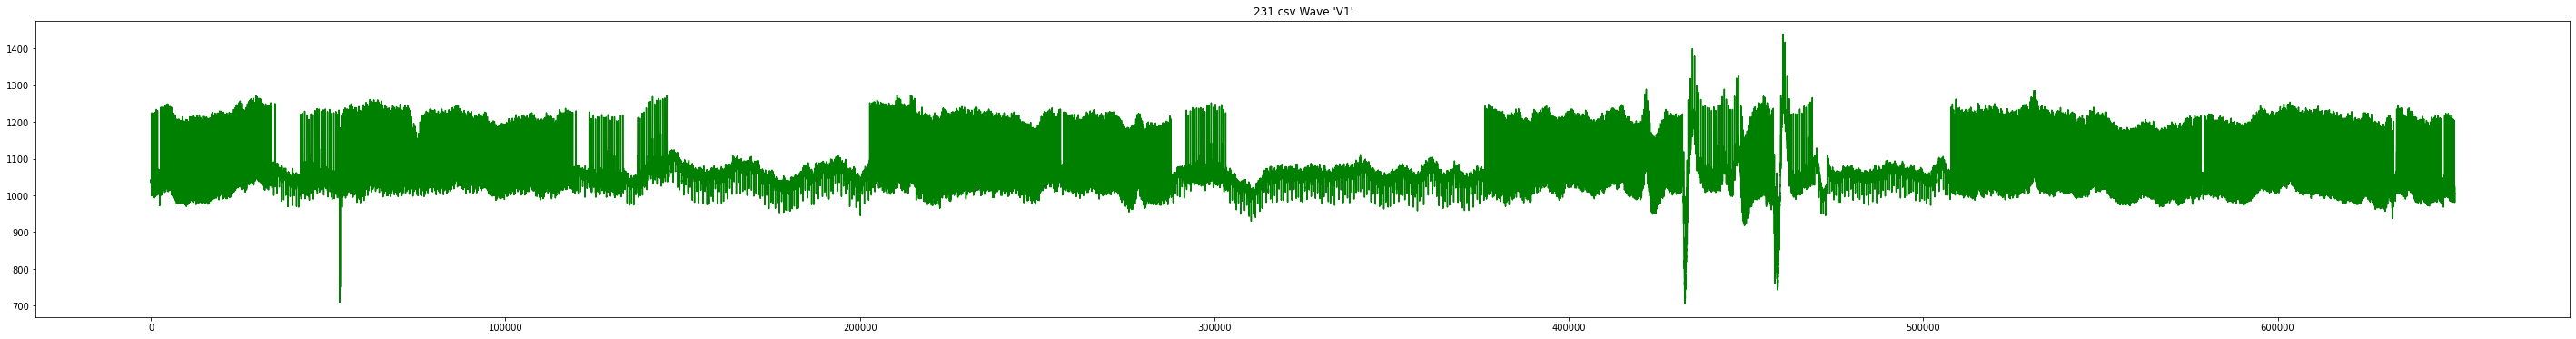

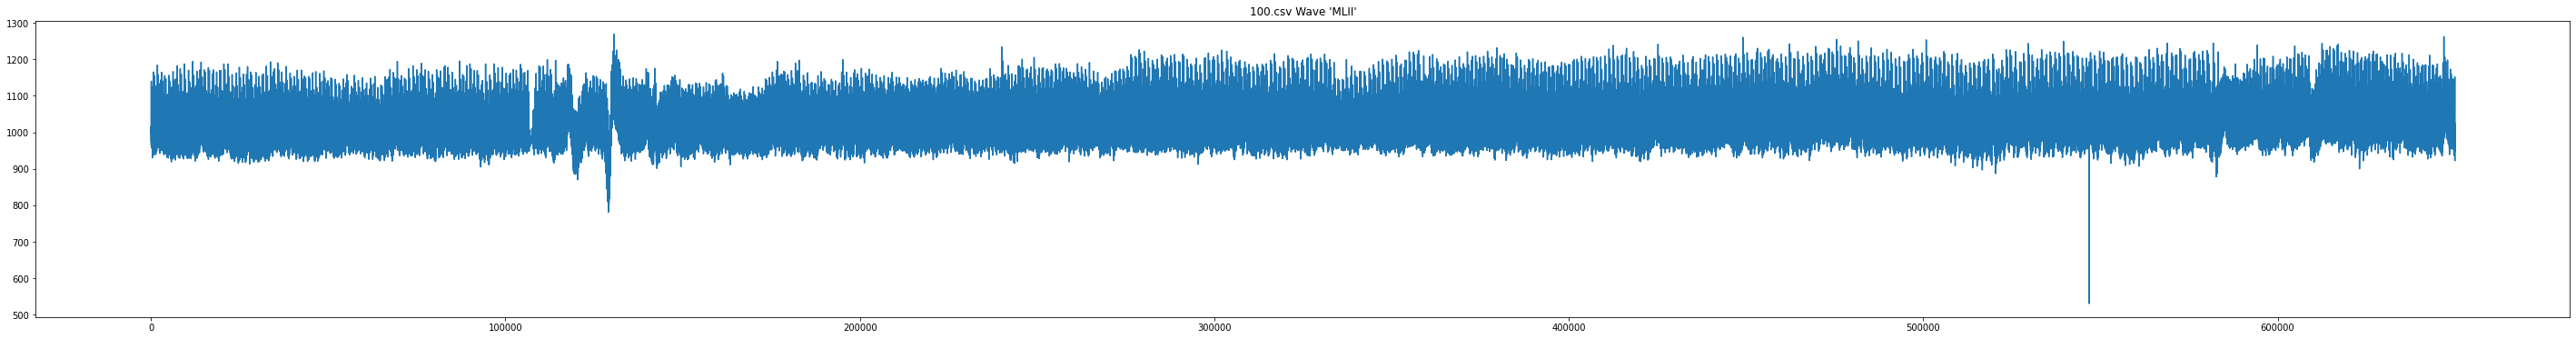

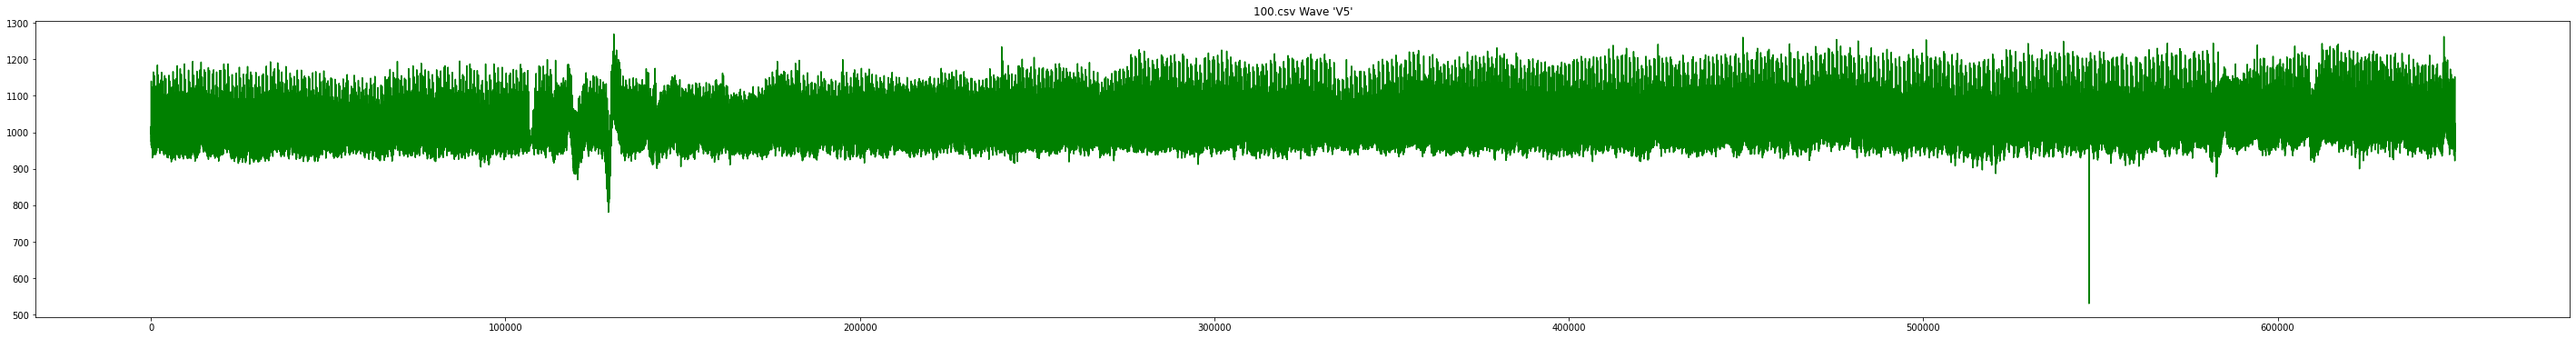

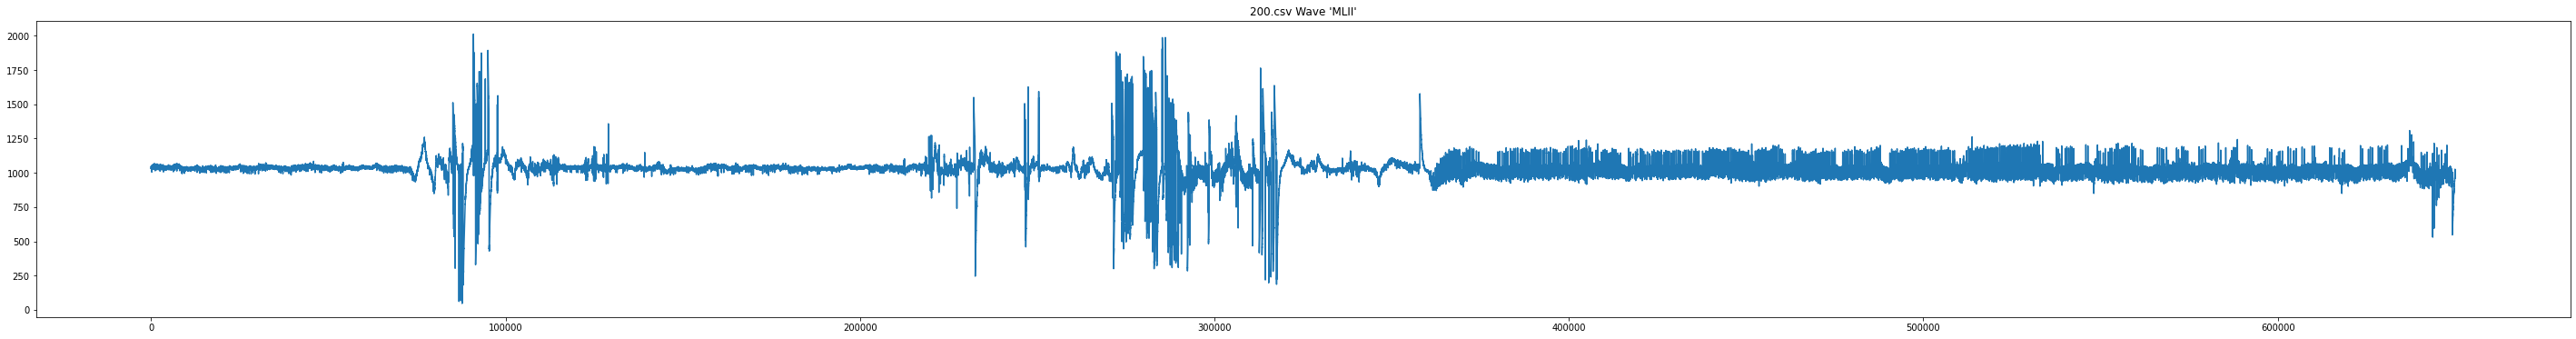

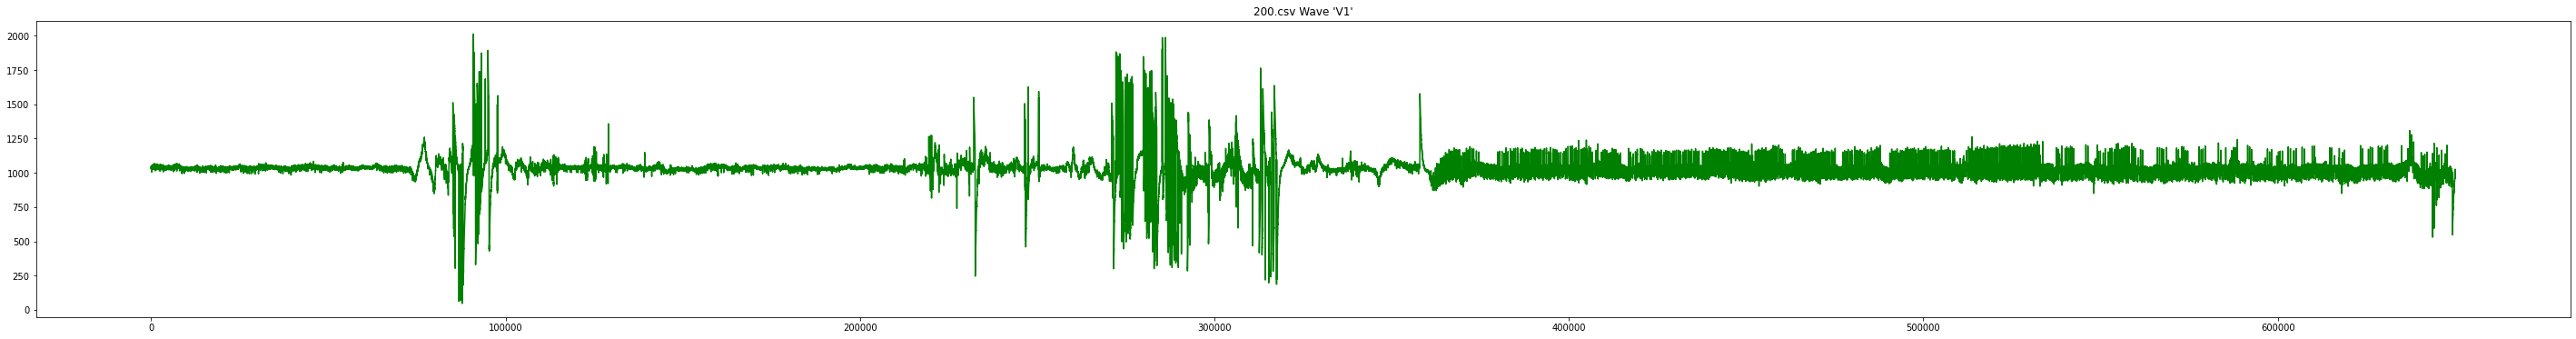

In [ ]:
rand_index = np.random.choice(nfiles, 10)

for j in rand_index:
    signal_1 = []
    signal_2 = []


    with open(files[j], 'rt') as csvfile:
        csvreader = csv.reader(csvfile, delimiter=',') # read csv
        row_index = -1
        for row in csvreader:
            if row_index < 0: elec_1, elec_2 = row[1:]
            if row_index >= 0:
                signal_1.insert(row_index, int(row[1]))
                signal_2.insert(row_index, int(row[2]))
            row_index += 1

    plt.title(files[j] + ' Wave ' + elec_1)
    plt.plot(signal_2)
    plt.show()

    plt.title(files[j] + ' Wave ' + elec_2)
    plt.plot(signal_2, color='green' )
    plt.show()

No discrepancies are detected. Both signals seem to be good and pretty much the same, we are just going to pick the first. (Seem to be ordered in popularity anyway)

### Processing the signal

https://physionet.org/physiobank/database/html/mitdbdir/intro.htm


The window size has been set knowing that for the ECMs we want several beats per window. 
By hand we have estimated that:

| Beats per window 	| Window size 	|
|:----------------:	|:-----------:	|
|         1        	|     140     	|
|         3        	|     340     	|
|         5        	|     720     	|
|         7        	|     1060     	|

In [ ]:
MAXPERCLASS = 10000  # we set a maximum number of all given types of arrhythmias to avoid overfitting on a specific type
WINDOW_SIZE = 340    # we want each window to have several beats

# classes = ['N', 'L', 'R', 'A', 'V', '/']
classes = ['N', 'L', 'R', 'A', 'V', '/',  'a', 'J', 'S', 'F', 'e', 'j', 'E', 'Q', 'x','f', '!', '[', ']']
nclasses = len(classes)
count_classes = np.zeros(nclasses)

In [ ]:
X = list()
y = list()

for i in range(0, nfiles):
# for i in range(0, 6):
    if i%6 == 0:
        print('{} files processed...'.format(i))

    # records
    signals = []

    with open(files[i], 'rt') as csvfile:
        csvreader = csv.reader(csvfile, delimiter=',') # read csv
        row_index = -1
        for row in csvreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1
            
    # anotations: R position and Arrhythmia class
    with open(annot[i], 'r') as fileID:
        data = fileID.readlines() 
        beat = list()

        ''' an annotations file looks like so:
        Time   Sample #  Type  Sub Chan  Num	Aux
        0:00.050   18     +    0    0    0	
        '''
        for d in range(1, len(data)):               # 0 is chart head
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted)                          # time
            pos = int(next(splitted))               # sample
            arr_type = next(splitted)               # type

            if arr_type in classes:
                arr_index = classes.index(arr_type)
                if count_classes[arr_index] > MAXPERCLASS: pass
                else:
                    '''
                    el beat debe ser simetrico:
                        comprobamos pos > WS porque sino se quedaría sin parte izq
                        comprobamos pos < (len(signals) - WINDOW_SIZE)) porque sino se quedaría sin parte dcha
                    '''
                    if (WINDOW_SIZE < pos and pos < (len(signals) - WINDOW_SIZE)):
                        beat = signals[pos-WINDOW_SIZE+1:pos+WINDOW_SIZE]
                        X.append(beat)
                        y.append(arr_index) # the label is the type of arrh
                    
                    count_classes[arr_index] += 1

0 files processed...
6 files processed...
12 files processed...
18 files processed...
24 files processed...
30 files processed...
36 files processed...
42 files processed...


In [ ]:
# data
print('X shape: ', np.shape(X))
print('y shape: ', np.shape(y))

X shape:  (35685, 679)
y shape:  (35685,)


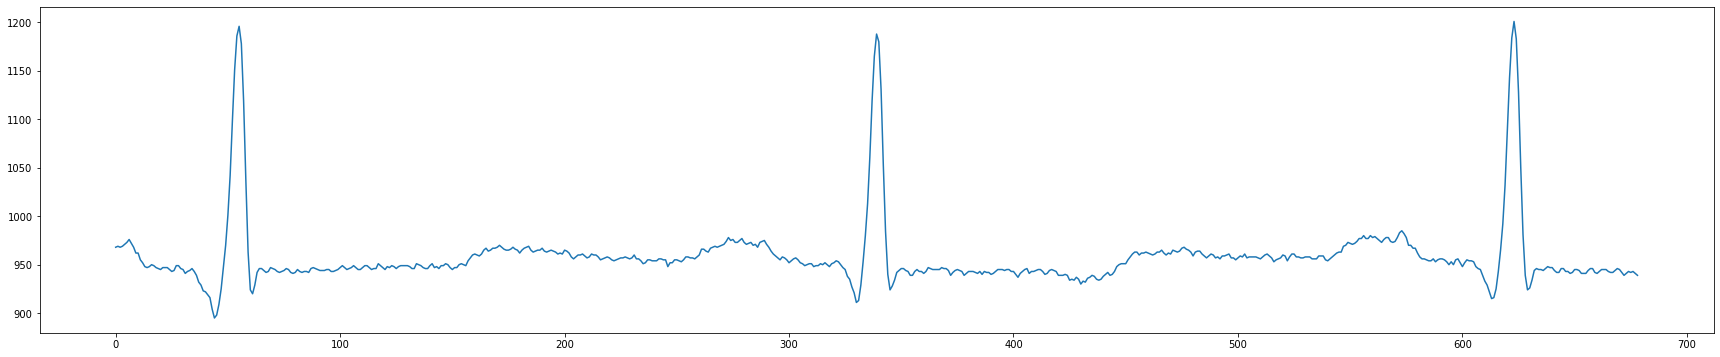

In [ ]:
# for the plot
i = 3

# beat plot
plt.plot(X[i])

### Denoising the signal
Filtro de paso bajo 40Hz

Low-pass filter, passes signals with a frequency lower than a certain cutoff frequency and attenuates signals with frequencies higher than the cutoff frequency

In [ ]:
fs = 360    # sample rate
T = 1/fs    # sample period
cutoff = 40 # cutoff freq of the filter Hz
nyq = 0.5 * fs

In [ ]:
def lowpass_filter(signal, cutoff, fs, order=2):
    normal_cutoff = cutoff / nyq
    
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, signal)

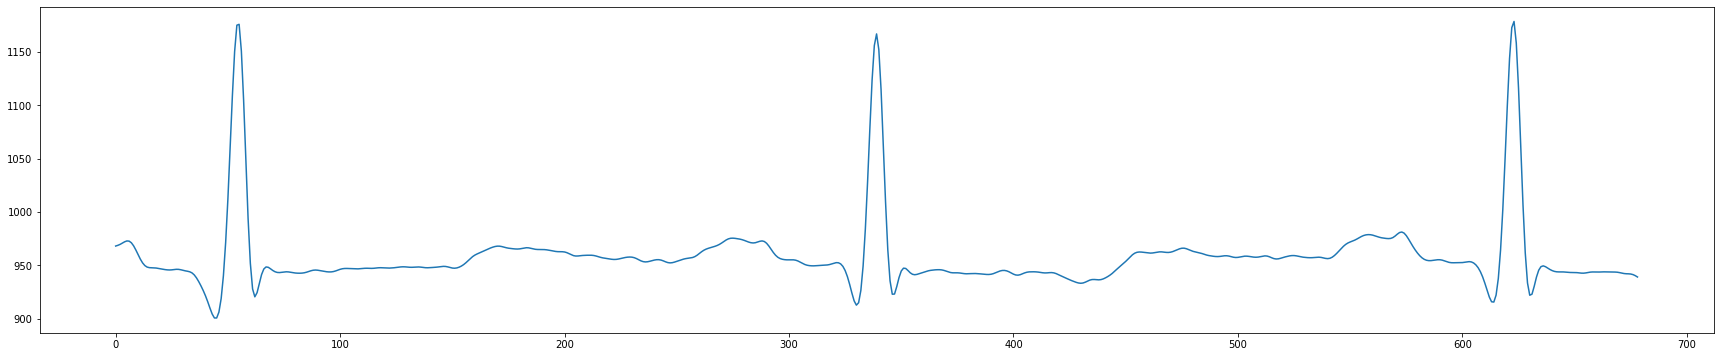

In [ ]:
# see how it affects 1 signal
lp = lowpass_filter(X[3], cutoff, fs)
plt.rcParams["figure.figsize"] = (30,6)
plt.plot(lp)

In [ ]:
# apply denoising to all
for i in range(0, len(X)):
    X[i] = lowpass_filter(X[i], cutoff, fs)

In [ ]:
X = np.asarray(X)
np.savetxt(path + 'allclasses_denoised_signals_3peak', X, delimiter=",")

y = np.asarray(y)
np.savetxt(path + 'allclasses_signals_classes_3peak', y, delimiter=",")

In [ ]:
X = np.loadtxt(path + 'allclasses_denoised_signals_3peak', delimiter=',')
y = np.loadtxt(path + 'allclasses_signals_classes_3peak', delimiter=',')

# X = np.loadtxt(path + 'denoised_signals_3peak', delimiter=',')
# y = np.loadtxt(path + 'signals_classes_3peak', delimiter=',')

print(X.shape)
print(y.shape)

(44984, 2119)
(44984,)


#### Instances of every class

In [ ]:
Xy = np.zeros( (X.shape[0], X.shape[1]+1) )

for i in range(0,len(X)):
    Xy[i] = np.append(X[i],y[i])
print(np.shape(Xy))

(35685, 680)


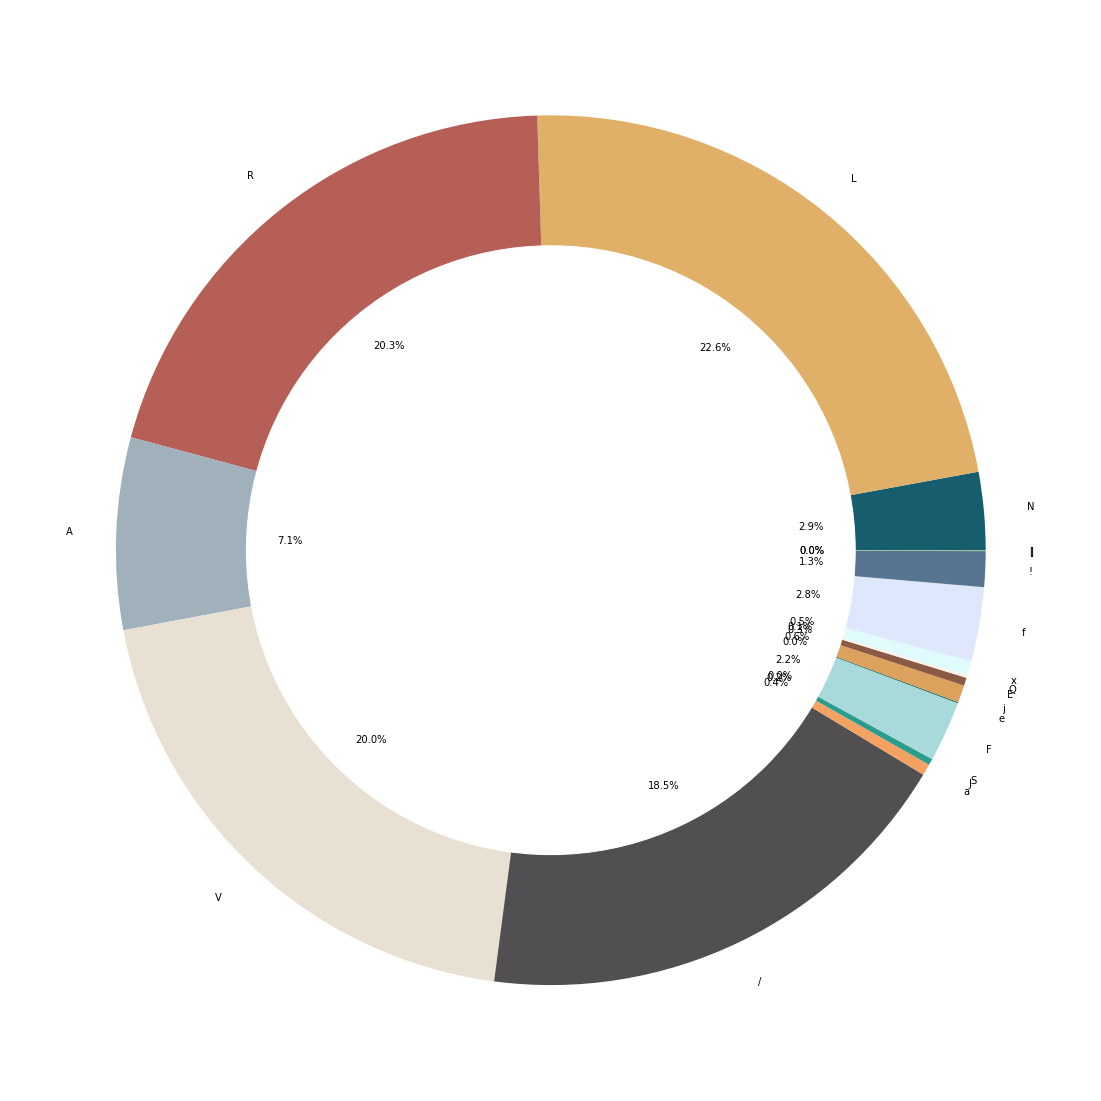

,arrhythmia,number
0.0,N,1031
1.0,L,8068
2.0,R,7251
3.0,A,2545
4.0,V,7126
5.0,/,6584
6.0,a,150
7.0,J,83
8.0,S,2
9.0,F,802


In [ ]:
# representation of instances of every class
df = pd.DataFrame(Xy)
per_class = df[df.shape[1]-1].value_counts()
per_class = per_class.sort_index()
auxdf = pd.DataFrame({'arrhythmia': classes, 'number': per_class})  


my_colors=['#165E6E','#E0B069','#B55F56','#A0B1BC','#E8E1D3','#514F51','#f4a261',
            '#2a9d8f', '#6b705c', '#a8dadc', '#2d6a4f', '#dda15e', '#8a5a44',
            '#fff1e6', '#e0fbfc', '#dfe7fd', '#577590', '#43aa8b', '#90be6d']

plt.figure(figsize=(20,20))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=classes, colors=my_colors, autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

display(auxdf)

# Create ECM


In [ ]:
X = np.loadtxt(path + 'allclasses_denoised_signals_3peak', delimiter=',')
y = np.loadtxt(path + 'allclasses_signals_classes_3peak', delimiter=',')

# X = np.loadtxt(path + 'denoised_signals_3peak', delimiter=',')
# y = np.loadtxt(path + 'signals_classes_3peak', delimiter=',')

print(X.shape)
print(y.shape)

(35685, 679)
(35685,)


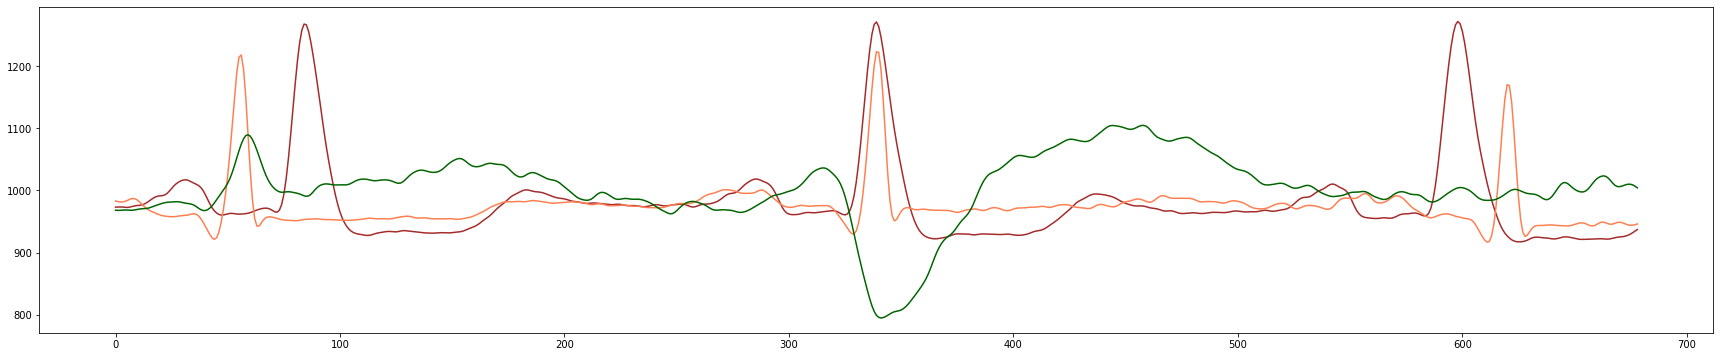

In [ ]:
npeaks = 3
indeces = np.random.choice(X.shape[0], npeaks)

colors = ['brown', 'coral','saddlebrown', 'orange', 'goldenrod', 'darkkhaki',
          'gold', 'lawngreen', 'darkgreen', 'mediumaquamarine', 'lightseagreen',
          'darkslategray', 'deepskyblue', 'dodgerblue', 'mediumslateblue',
          'darkorchid', 'fuchsia']
colors.sort() # so that all signals are not in similar shades

for i, index in enumerate(indeces):
    plt.plot(X[index], color=colors[i])

## Heatmaps

We procede to create heatmaps where each row of the heatmap represents 2 of the peaks of a window.

So for a 3 window peak:
1.   1st row will show peak_1 and peak_2
2.   2nd row will show peak_2 and peak_3

For a 5 window peak:
1.   1st row will show peak_1 and peak_2
2.   2nd row will show peak_2 and peak_3
3.   3rd row will show peak_3 and peak_4
4.   2nd row will show peak_4 and peak_5

And so forth.

**For *npeak* peaks, the matrix of signals will have *npeaks-2* rows.**

#### Splitting one signal to see what happens

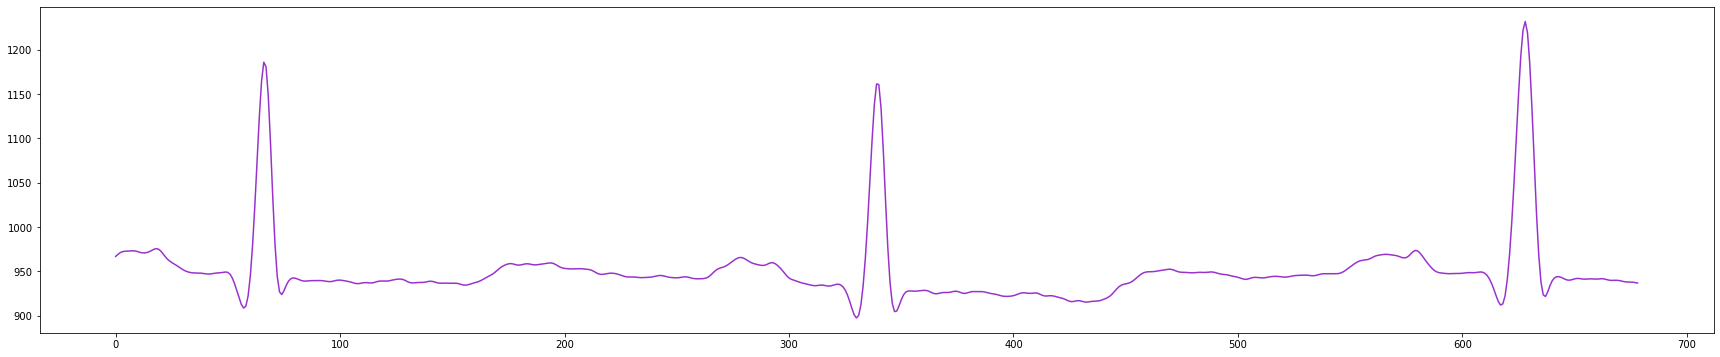

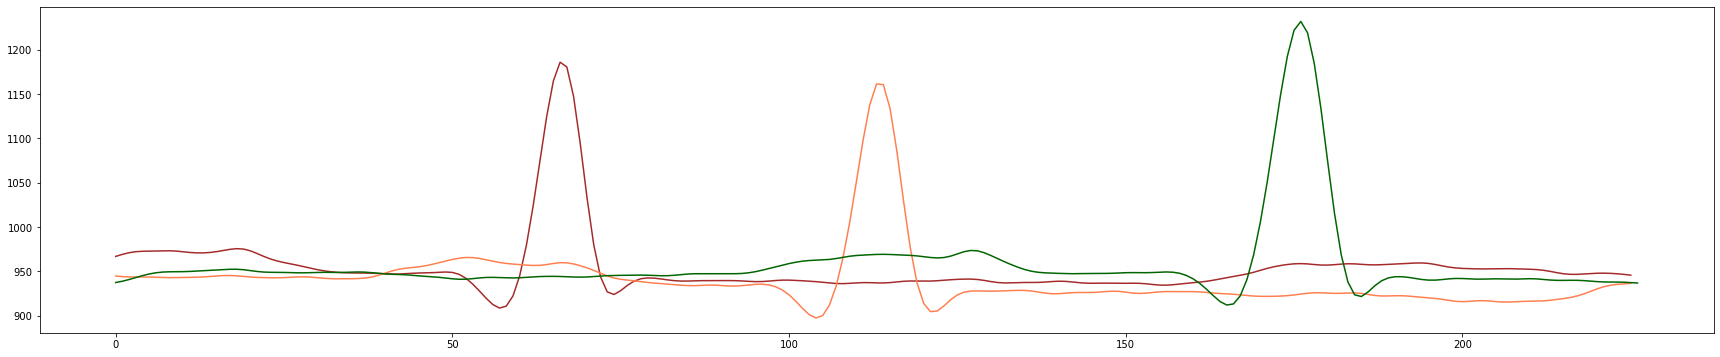

In [ ]:
plt.rcParams["figure.figsize"] = (30,6)

npeaks = 1
indeces = np.random.choice(X.shape[0], npeaks)

colors = ['brown', 'coral','saddlebrown', 'orange', 'goldenrod', 'darkkhaki',
          'gold', 'lawngreen', 'darkgreen', 'mediumaquamarine', 'lightseagreen',
          'darkslategray', 'deepskyblue', 'dodgerblue', 'mediumslateblue',
          'darkorchid', 'fuchsia']
colors.sort() # so that all signals are not in similar shades

plt.plot(X[indeces[0]], color=colors[4])
plt.show()

siglen = X.shape[1]
peaks = 3
for i in range(peaks):
    lower = int(i*(siglen/peaks))
    upper = int((i+1)*(siglen/peaks))
    plt.plot(X[indeces[0]][lower:upper], color=colors[i])

In [ ]:
a = np.random.rand(1, 2)
b = a * 2
c = a * 3
split_signals = [a,b,c]

matrix = np.zeros( (npeaks-1, split_signals[0].shape[1]*2) )
for j in range(npeaks-1):
    matrix[j] = np.ravel(np.concatenate( (split_signals[j], split_signals[j+1]) , axis=1))

### Creating matrices

In [ ]:
npeaks = 7
indeces = []

# define the split indeces
for i in range(1, npeaks):
    if i == 1 : indeces.append( int( X.shape[1]/npeaks) )
    else: indeces.append( int(X.shape[1]/npeaks)*i )

In [ ]:
# maxshape = int(np.ceil(X.shape[1]/npeaks))                        # for padding
maxshape = int(X.shape[1]/npeaks)+(X.shape[1]-int(X.shape[1]/npeaks)*npeaks)                        # for padding npeak7
matrix_shape_cols = int(np.floor(X.shape[1]/npeaks)) + maxshape   # each matrix will have this num of cols
matrices = np.zeros( (X.shape[0], npeaks-1, matrix_shape_cols) )  # store all matrices created, 

# for i in range(4):
for i in range(X.shape[0]):
    split_signals = np.split(X[i], indices_or_sections=indeces)   # this is a list
    
    matrix = np.zeros( (npeaks-1, matrix_shape_cols) )  # matrix will store the concatenated pieces of signal
    for j in range(npeaks-1):
        aux = np.ravel(np.concatenate( (split_signals[j], split_signals[j+1])))              # signal concat 
        if aux.shape[0] < matrix_shape_cols:
            pad = np.repeat(aux[-1], matrix_shape_cols-aux.shape[0])
            aux = np.append(aux, pad)                   # add padding at end  npeak7
            # aux = np.append(aux, aux[-1])                   # add padding at end 

        matrix[j] = aux # store signal in matrix
    
    matrices[i, :, :] = matrix
# matrices[:,:,0].shape this is the matrix of one row of X
matrices.shape

(44984, 6, 609)

In [ ]:
np.save(path + 'allclasses_ecm_matrices_3peak', matrices)
# np.save(path + 'ecm_matrices_3peak', matrices)

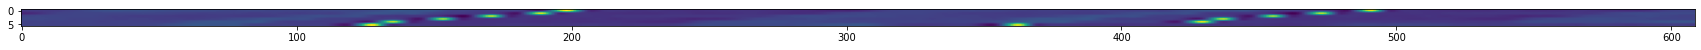

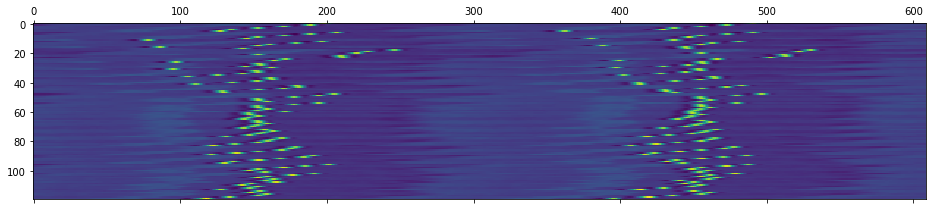

In [ ]:
plt.rcParams["figure.figsize"] = (30,20)
plt.imshow(matrices[0,:,:])

necms = 20
several = matrices[:necms, :, :].reshape((matrices.shape[1]*necms, matrices.shape[2]))
plt.matshow(several)

# Train, test split

In [8]:
# classes = ['N', 'L', 'R', 'A', 'V', '/']
classes = ['N', 'L', 'R', 'A', 'V', '/',  'a', 'J', 'S', 'F', 'e', 'j', 'E', 'Q', 'x','f', '!', '[', ']']
nclasses = len(classes)

print(nclasses)

19


In [ ]:
# matrices = np.load(path + 'ecm_matrices_3peak.npy')
matrices = np.load(path + 'allclasses_ecm_matrices_3peak.npy')
# matrices = np.load(path + 'allclasses_ecm_matrices_7peak.npy')
matrices.shape

(35685, 2, 453)

In [ ]:
# y = np.loadtxt(path + 'signals_classes_3peak', delimiter=',')
y = np.loadtxt(path + 'allclasses_signals_classes_3peak', delimiter=',')
# y = np.loadtxt(path + 'allclasses_signals_classes_7peak', delimiter=',')
y.shape

(35685,)

In [ ]:
# divide dataset 
test_ratio = 0.3
valid_ratio = 0.2

x_train, x_test, y_train, y_test = train_test_split(matrices, y, test_size=test_ratio)
# x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=valid_ratio)

y_train = to_categorical(y_train, num_classes=nclasses)
# y_val = to_categorical(y_val)
y_test = to_categorical(y_test, num_classes=nclasses)

print("x_train : ", x_train.shape)
# print("x_val : ", x_val.shape)
print("x_test  : ", x_test.shape)
print()
print("y_train : ", y_train.shape)
# print("y_val : ", y_val.shape)
print("y_test  : ", y_test.shape)

x_train :  (24979, 2, 453)
x_test  :  (10706, 2, 453)

y_train :  (24979, 19)
y_test  :  (10706, 19)


# Networks

In [6]:
import torch
from torch import nn
from torch import optim

In [7]:
from keras import Input
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Softmax, BatchNormalization, Activation
from keras.layers import Conv1D, Conv2D, Bidirectional, LSTM, MaxPool2D, MaxPooling1D

from keras.callbacks import ModelCheckpoint, Callback
from keras.models import load_model

from keras.utils.vis_utils import plot_model

## Common Callbacks


In [ ]:
from timeit import default_timer as timer

class TimingCallback(Callback):
    def __init__(self, logs={}):
        self.logs=[]

    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

In [ ]:
class MonitorCallback(Callback):
    best_train_loss = 10000.02
    best_val_loss = 10000.02

    def on_epoch_end(self, epoch, logs={}): 
        current_val = logs.get('val_loss')
        current_train = logs.get('loss')

        if (current_train < self.best_train_loss and current_val < self.best_val_loss):
            self.best_train_loss = current_train
            self.best_val_loss = current_val
            model.save(filepath)
            print('Saved model with train loss %.4f and val loss %.4f at epoch %d' % (current_train, current_val, epoch+1))

# best_val_loss = sys.float_info.max 
# def saveModel(epoch,logs):
#     val_acc = logs['val_acc']
#     val_loss = logs['val_loss']

#     if val_acc > best_val_acc:
#         best_val_acc = val_acc
#         model.save(...)
#     elif val_acc == best_val_acc:
#         if val_loss < best_val_loss:
#             best_val_loss=val_loss
#             model.save(...)
# callbacks = [LambdaCallback(on_epoch_end=saveModel)]

## CNN


### Model

In [ ]:
# CONV => RELU => POOL
model = Sequential(name='conv_relu_pool')
inputShape = (x_train.shape[1], x_train.shape[2])

model.add(Conv1D(filters=64, kernel_size=1, strides=1, input_shape=inputShape, name='conv_1'))
model.add(Activation("relu"))
model.add(BatchNormalization())

model.add(Conv1D(filters=64, kernel_size=1, strides=1, name='conv_2'))
model.add(Activation("relu"))
model.add(BatchNormalization())

model.add(MaxPooling1D())
model.add(Dropout(0.25))

model.add(Conv1D(filters=128, kernel_size=1, strides=1, name='conv_3'))
model.add(Activation("relu"))
model.add(BatchNormalization())

model.add(Conv1D(filters=128, kernel_size=1, strides=1, name='conv_4'))
model.add(Activation("relu"))
model.add(BatchNormalization())

# model.add(MaxPooling1D())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# softmax classifier
model.add(Dense(nclasses, activation='softmax', name='dense_2'))

# model.summary()

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics= ['accuracy'])

In [ ]:
plot_model(model, to_file='cnn_model.png', show_shapes=True, show_layer_names=True)

In [ ]:
# define the checkpoint
EPOCHS = 200
NPEAKS = '7PEAKS'

filepath = path + "allclasses_conv_relu_pool_bestscores_{}_{}.hdf5".format(EPOCHS, NPEAKS)
checkpoint_train = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

# filepath_val = path + "allclasses_val_conv_relu_pool_{}.hdf5".format(EPOCHS)
# checkpoint_val = ModelCheckpoint(filepath_val, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

callbacks_list = [checkpoint_train]

In [ ]:
# H = model.fit(x_train, y_train, validation_split=0.2, epochs=EPOCHS, verbose=1, callbacks=callbacks_list)

tc = TimingCallback()
callbacks = [MonitorCallback(), tc]

H = model.fit(x_train, y_train, validation_split=0.2, epochs=200, verbose=1, callbacks=callbacks)

print('TOTAL TIME: ', sum(tc.logs))

# Save model
model.save(path + "allclasses_conv_relu_pool_endoftraining_{}_{}.h5".format(EPOCHS, NPEAKS))

Epoch 1/200
788/788 [==============================] - 34s 17ms/step - loss: 0.3488 - accuracy: 0.5656 - val_loss: 0.3730 - val_accuracy: 0.2183
Saved model with train loss 0.1550 and val loss 0.3730 at epoch 1
Epoch 2/200
788/788 [==============================] - 13s 16ms/step - loss: 0.0432 - accuracy: 0.8783 - val_loss: 0.3929 - val_accuracy: 0.2201
Epoch 3/200
788/788 [==============================] - 12s 16ms/step - loss: 0.0329 - accuracy: 0.9041 - val_loss: 0.2949 - val_accuracy: 0.2925
Saved model with train loss 0.0313 and val loss 0.2949 at epoch 3
Epoch 4/200
788/788 [==============================] - 12s 16ms/step - loss: 0.0287 - accuracy: 0.9173 - val_loss: 0.3184 - val_accuracy: 0.2625
Epoch 5/200
788/788 [==============================] - 12s 16ms/step - loss: 0.0225 - accuracy: 0.9351 - val_loss: 0.2203 - val_accuracy: 0.3161
Saved model with train loss 0.0227 and val loss 0.2203 at epoch 5
Epoch 6/200
788/788 [==============================] - 12s 16ms/step - loss: 

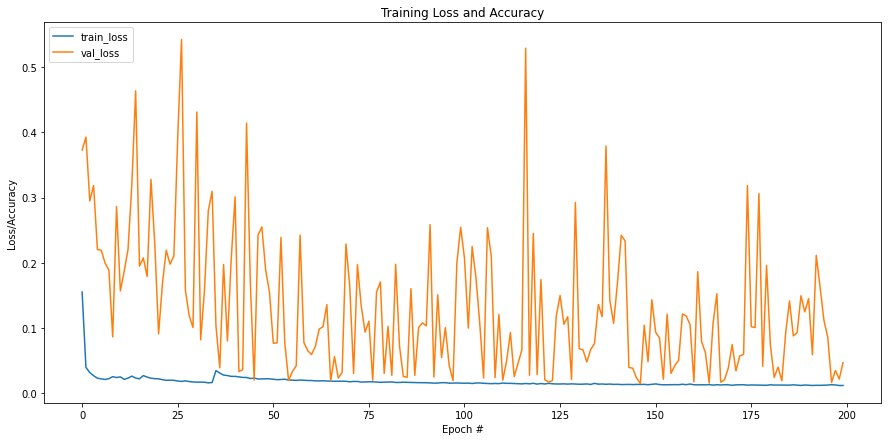

In [ ]:
# plot the training loss and accuracy
plt.figure(figsize=(15,7))

plt.plot(np.arange(0, EPOCHS), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, EPOCHS), H.history["val_loss"], label="val_loss")

# plt.plot(np.arange(0, EPOCHS), H.history["accuracy"], label="train_acc")
# plt.plot(np.arange(0, EPOCHS), H.history["val_accuracy"], label="val_acc")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")

pltname = path + 'allclasses_conv_relu_pool_{}_{}.png'.format(EPOCHS, NPEAKS)
plt.savefig(pltname)

### Evaluation

In [ ]:
EPOCHS = 200
NPEAKS = '7PEAKS'

filepath = path + "allclasses_conv_relu_pool_bestscores_{}_{}.hdf5".format(EPOCHS, NPEAKS)

# load the model
model = load_model(filepath)

In [ ]:
print("Evaluate on test data")
results = model.evaluate(x_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
422/422 [==============================] - 2s 5ms/step - loss: 0.0501 - accuracy: 0.8849
test loss, test acc: [0.05012064054608345, 0.8849288821220398]


In [ ]:
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

ided_classes = list(np.unique(y_pred)) # classes that have been found
y_pred = to_categorical(y_pred)

missing_classes = []
if y_pred.shape[1] != y_test.shape[1]:
    y_pred = np.asmatrix(y_pred)
    aux = np.zeros( (y_pred.shape[0], 1) )
    
    y_test_numerical =  np.unique(np.asarray([ np.argmax(test) for test in y_test ]))
    missing_classes = [l for l in y_test_numerical if l not in ided_classes]

    for m in missing_classes:
        if m == 18: y_pred = np.hstack((y_pred, aux))
        else: 
            pre = y_pred[:,:m]
            post = y_pred[:,m:]
            y_pred = np.column_stack((pre, aux, post))
        
# y_pred.shape, y_test.shape
cms = multilabel_confusion_matrix(y_test, y_pred)

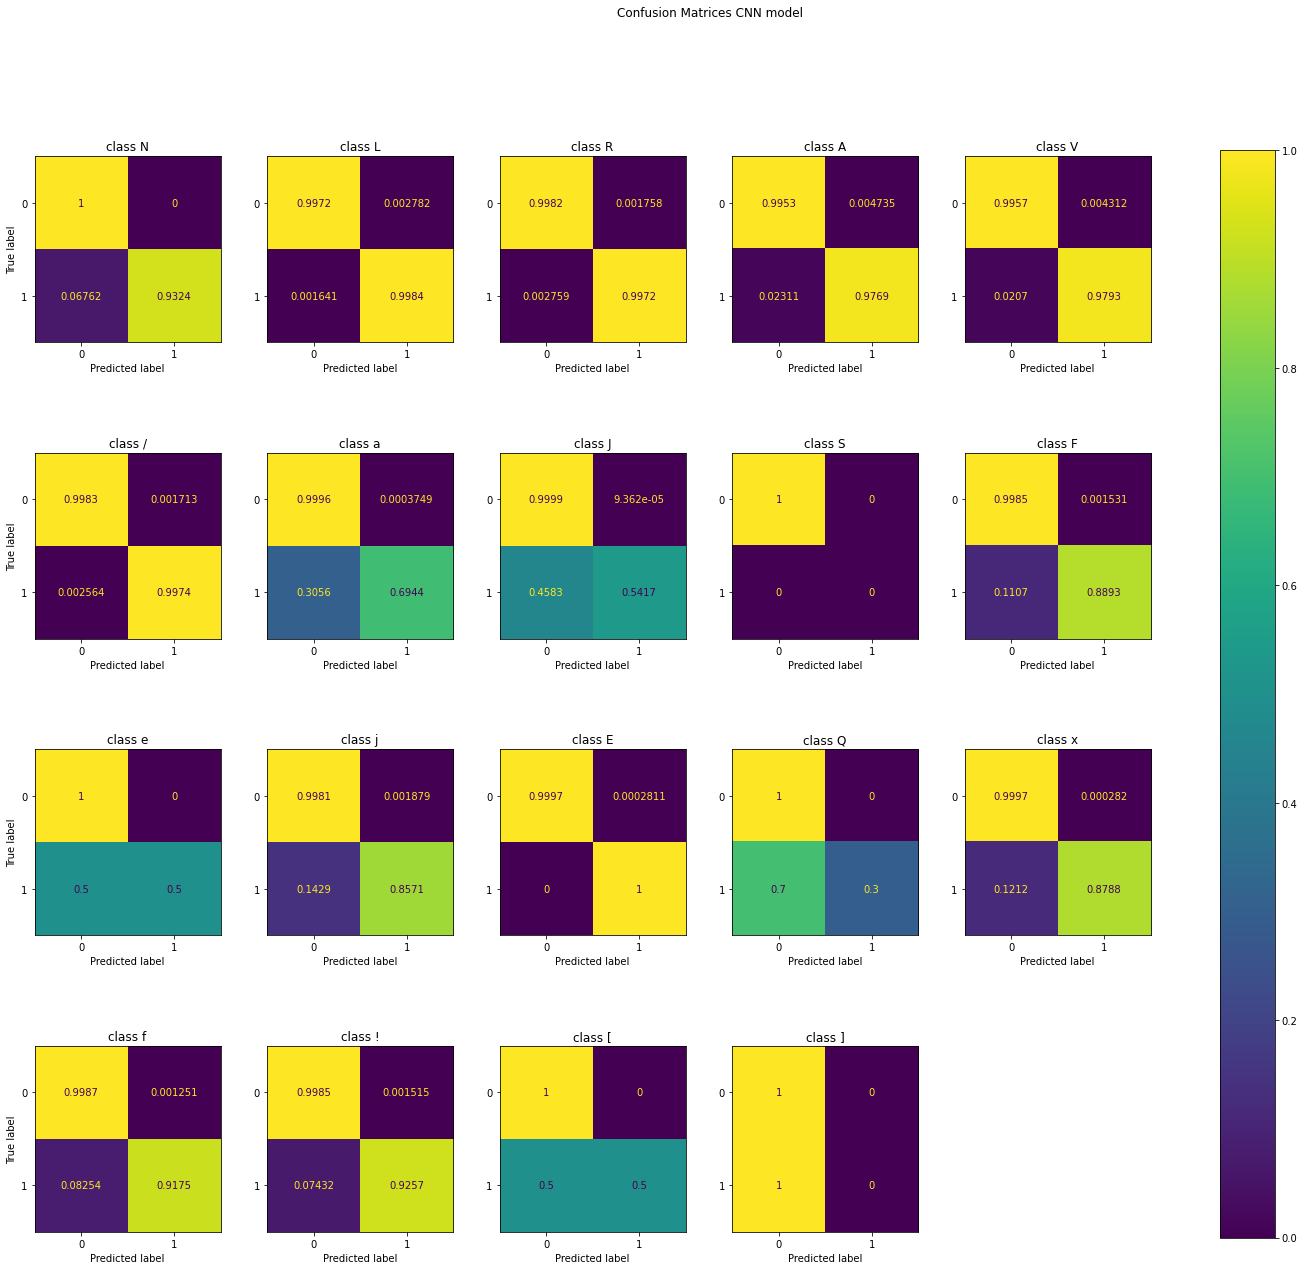

In [ ]:
f, axes = plt.subplots(4, 5, figsize=(25, 20))
axes = axes.ravel()
for i in range(nclasses):
    norm_cm = normalize(cms[i], axis=1, norm='l1')
    disp = ConfusionMatrixDisplay(confusion_matrix=norm_cm, display_labels=[0, 1])
    # disp = ConfusionMatrixDisplay(confusion_matrix=cms[i], display_labels=[0, i])
    
    disp.plot(ax=axes[i], values_format='.4g')
    disp.ax_.set_title(f'class '+classes[i])
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.25, hspace=0.5)
f.suptitle('Confusion Matrices CNN model')
f.delaxes(ax=axes[-1])
f.colorbar(disp.im_, ax=axes)

pltname = path + 'cnn_model_confmatrices.png'
plt.savefig(pltname)

plt.show()

In [ ]:
# cms_cnn = cms
# np.save(path + 'cnn_confmatrix_3peak', cms_cnn)
cms_cnn = np.load(path + 'cnn_confmatrix_3peak.npy')

tn = cms_cnn[:, 0, 0]
tp = cms_cnn[:, 1, 1]
fn = cms_cnn[:, 1, 0]
fp = cms_cnn[:, 0, 1]

cnn_df = pd.DataFrame(data={'TN':tn, 'TP':tp, 'FN':fn, 'FP':fp})
cnn_df.index=classes

In [ ]:
# from matplotlib import cm

# y_pred = model.predict(x_test)
# y_pred = np.argmax(y_pred, axis=1)

# y_pred_numerical = np.asarray([ np.argmax(pred) for pred in y_pred ])
# y_test_numerical =  np.asarray([ np.argmax(test) for test in y_test ])

# confmatrix = evaluate.confusion_matrix(y_target=y_test_numerical, 
#                       y_predicted=y_pred_numerical, 
#                       binary=False)

# plt.rcParams["figure.figsize"] = (15,15)
# fig, ax = plotting.plot_confusion_matrix(conf_mat=confmatrix, cmap=cm.YlGn)
# # c = plt.pcolor(confmatrix, edgecolors='k', linewidths=4, cmap=cm.YlGn, vmin=0.0, vmax=1.0)
# plt.colorbar(c)
# plt.show()

## CNN+LSTM


### Model


In [ ]:
# CNN same as before
model = Sequential(name='allclasses_conv_relu_pool_lstm')
inputShape = (x_train.shape[1], x_train.shape[2])

model.add(Conv1D(filters=64, kernel_size=1, strides=1, input_shape=inputShape, name='conv_1'))
model.add(Activation("relu"))
model.add(BatchNormalization())

model.add(Conv1D(filters=64, kernel_size=1, strides=1, name='conv_2'))
model.add(Activation("relu"))
model.add(BatchNormalization())

model.add(MaxPooling1D())
model.add(Dropout(0.25))

model.add(Conv1D(filters=128, kernel_size=1, strides=1, name='conv_3'))
model.add(Activation("relu"))
model.add(BatchNormalization())

model.add(Conv1D(filters=128, kernel_size=1, strides=1, name='conv_4'))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.25))

# add LSTM
model.add(LSTM(200))
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(rate=0.05))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# softmax classifier
model.add(Dense(nclasses, activation='softmax', name='final_dense'))

# model.summary()

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics= ['accuracy'])

In [ ]:
plot_model(model, to_file='cnn+lstm_model.png', show_shapes=True, show_layer_names=True)

In [ ]:
# define the checkpoint
NPEAKS = '7PEAKS'
EPOCHS = 200

filepath = path + "allclasses_conv_relu_pool_lstm_bestscores_{}_{}.hdf5".format(EPOCHS,NPEAKS)
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [ ]:
# H = model.fit(x_train, y_train, validation_split=0.2, epochs=EPOCHS, verbose=1, callbacks=callbacks_list)

tc = TimingCallback()
callbacks = [MonitorCallback(), tc]

H = model.fit(x_train, y_train, validation_split=0.2, epochs=EPOCHS, verbose=1, callbacks=callbacks)

print('TOTAL TIME: ', sum(tc.logs))

# Save model
model.save(path +'allclasses_conv_relu_pool_lstm_endoftraining_{}_{}.h5'.format(EPOCHS, NPEAKS))

Epoch 1/200
788/788 [==============================] - 28s 25ms/step - loss: 0.2566 - accuracy: 0.5856 - val_loss: 0.2617 - val_accuracy: 0.2305
Saved model with train loss 0.1174 and val loss 0.2617 at epoch 1
Epoch 2/200
788/788 [==============================] - 18s 23ms/step - loss: 0.0416 - accuracy: 0.8691 - val_loss: 0.2111 - val_accuracy: 0.2142
Saved model with train loss 0.0391 and val loss 0.2111 at epoch 2
Epoch 3/200
788/788 [==============================] - 18s 23ms/step - loss: 0.0311 - accuracy: 0.9037 - val_loss: 0.2546 - val_accuracy: 0.2418
Epoch 4/200
788/788 [==============================] - 18s 23ms/step - loss: 0.0282 - accuracy: 0.9131 - val_loss: 0.1687 - val_accuracy: 0.2858
Saved model with train loss 0.0272 and val loss 0.1687 at epoch 4
Epoch 5/200
788/788 [==============================] - 19s 24ms/step - loss: 0.0260 - accuracy: 0.9189 - val_loss: 0.3561 - val_accuracy: 0.2096
Epoch 6/200
788/788 [==============================] - 19s 24ms/step - loss: 

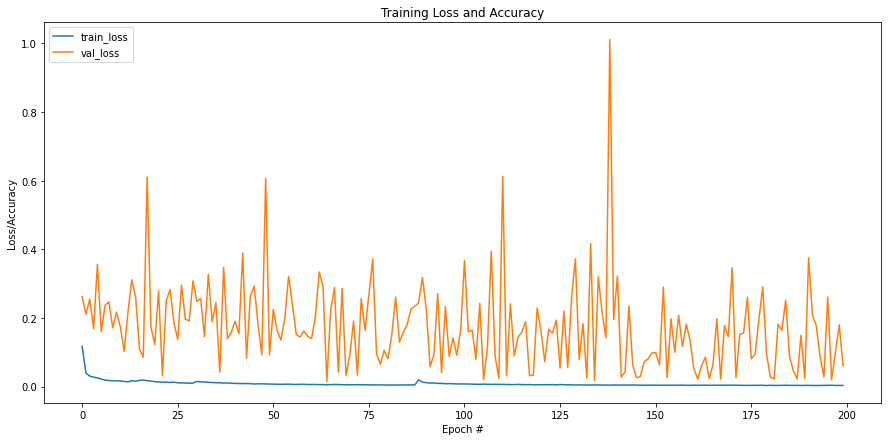

In [ ]:
# plot the training loss and accuracy
plt.figure(figsize=(15,7))

plt.plot(np.arange(0, EPOCHS), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, EPOCHS), H.history["val_loss"], label="val_loss")
#plt.plot(np.arange(0, EPOCHS), H.history["accuracy"], label="train_acc")
#plt.plot(np.arange(0, EPOCHS), H.history["val_accuracy"], label="val_acc")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")

pltname = path + 'allclasses_conv_relu_pool_lstm_{}_{}.png'.format(EPOCHS, NPEAKS)
plt.savefig(pltname)

### Evaluation

In [ ]:
EPOCHS = 200
NPEAKS = '7PEAKS'

filepath = path + "allclasses_conv_relu_pool_lstm_bestscores_{}_{}.hdf5".format(EPOCHS, NPEAKS)

# load the model
model = load_model(filepath)

In [ ]:
print("Evaluate on test data")
results = model.evaluate(x_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
422/422 [==============================] - 3s 7ms/step - loss: 0.0642 - accuracy: 0.8464
test loss, test acc: [0.06424912810325623, 0.8463989496231079]


In [ ]:
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

ided_classes = list(np.unique(y_pred)) # classes that have been found
y_pred = to_categorical(y_pred)

missing_classes = []
if y_pred.shape[1] != y_test.shape[1]:
    y_pred = np.asmatrix(y_pred)
    aux = np.zeros( (y_pred.shape[0], 1) )
    
    y_test_numerical =  np.unique(np.asarray([ np.argmax(test) for test in y_test ]))
    missing_classes = [l for l in y_test_numerical if l not in ided_classes]

    for m in missing_classes:
        if m == 18: y_pred = np.hstack((y_pred, aux))
        else: 
            pre = y_pred[:,:m]
            post = y_pred[:,m:]
            y_pred = np.column_stack((pre, aux, post))
        
# y_pred.shape, y_test.shape
cms = multilabel_confusion_matrix(y_test, y_pred)

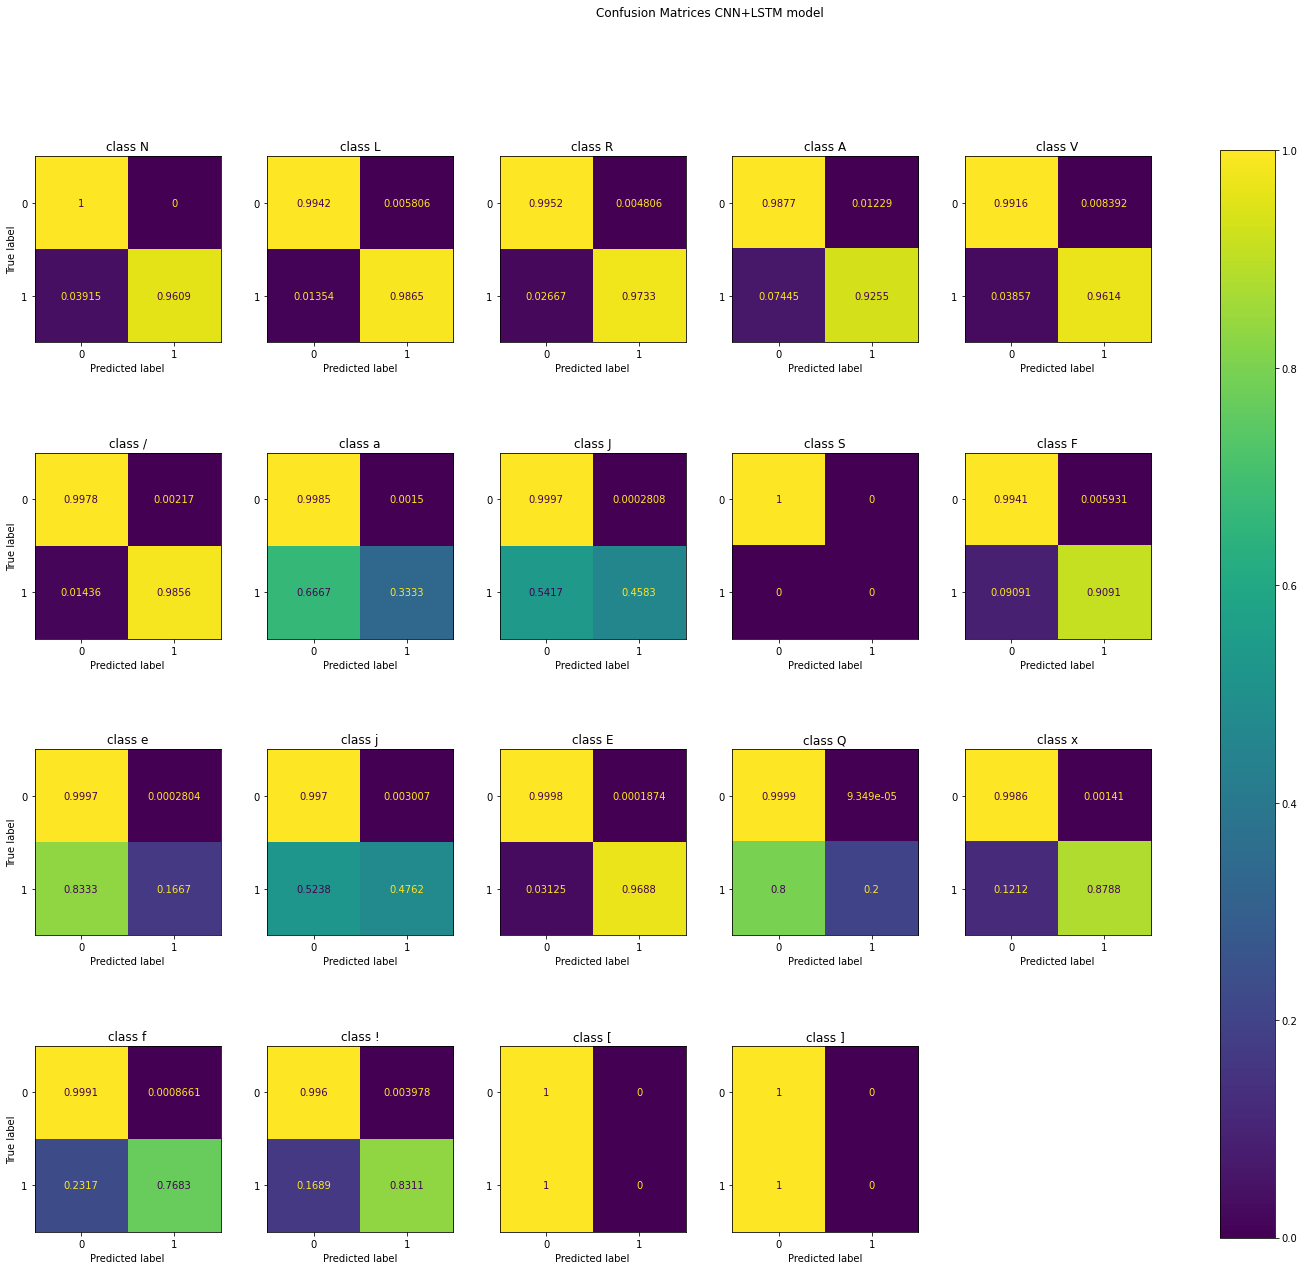

In [ ]:
f, axes = plt.subplots(4, 5, figsize=(25, 20))
axes = axes.ravel()
for i in range(nclasses):
    norm_cm = normalize(cms[i], axis=1, norm='l1')
    disp = ConfusionMatrixDisplay(confusion_matrix=norm_cm, display_labels=[0, 1])
    
    disp.plot(ax=axes[i], values_format='.4g')
    disp.ax_.set_title(f'class '+classes[i])
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.25, hspace=0.5)
f.suptitle('Confusion Matrices CNN+LSTM model')
f.delaxes(ax=axes[-1])
f.colorbar(disp.im_, ax=axes)

pltname = path + 'cnnlstm_model_confmatrices.png'
plt.savefig(pltname)

plt.show()

In [ ]:
# cms_cnnlstm = cms
# np.save(path + 'cnnlstm_confmatrix_3peak', cms_cnnlstm)
cms_cnnlstm = np.load(path + 'cnnlstm_confmatrix_3peak.npy')

tn = cms_cnnlstm[:, 0, 0]
tp = cms_cnnlstm[:, 1, 1]
fn = cms_cnnlstm[:, 1, 0]
fp = cms_cnnlstm[:, 0, 1]

cnnlstm_df = pd.DataFrame(data={'TN':tn, 'TP':tp, 'FN':fn, 'FP':fp})
cnnlstm_df.index=classes
results_dfs = [cnn_df, cnnlstm_df]

## CNN vs CNN+LSTM eval

In [ ]:
results_dfs[0]

,TN,TP,FN,FP
N,10413,281,12,0
L,8191,2436,25,54
R,8531,2076,51,48
A,9828,716,52,110
V,8468,2087,91,60
/,8717,1928,41,20
a,10654,15,21,16
J,10674,11,17,4
S,10706,0,0,0
F,10422,187,30,67


In [ ]:
metrics_df = []

for r in results_dfs:
    recall = r['TP'] / (r['TP']+r['FN'])
    specif = r['TN'] / (r['TN'] + r['FP'])
    fall_out =  r['FP'] / (fp + r['TN'])
    miss_rate = r['FN'] / (r['FN'] + r['TP'])
    
    df = pd.DataFrame(data={'recall': recall,
                            'specificity':specif,
                            'fallout': fall_out,
                            'missrate': miss_rate})
    df = df.fillna(0)
    df = df.round(decimals=4)

    metrics_df.append(df)
    
metrics_df[0]

,recall,specificity,fallout,missrate
N,0.9590,1.0000,0.0000,0.0410
L,0.9898,0.9935,0.0066,0.0102
R,0.9760,0.9944,0.0056,0.0240
A,0.9323,0.9889,0.0111,0.0677
V,0.9582,0.9930,0.0070,0.0418
/,0.9792,0.9977,0.0023,0.0208
a,0.4167,0.9985,0.0015,0.5833
J,0.3929,0.9996,0.0004,0.6071
S,0.0000,1.0000,0.0000,0.0000
F,0.8618,0.9936,0.0064,0.1382


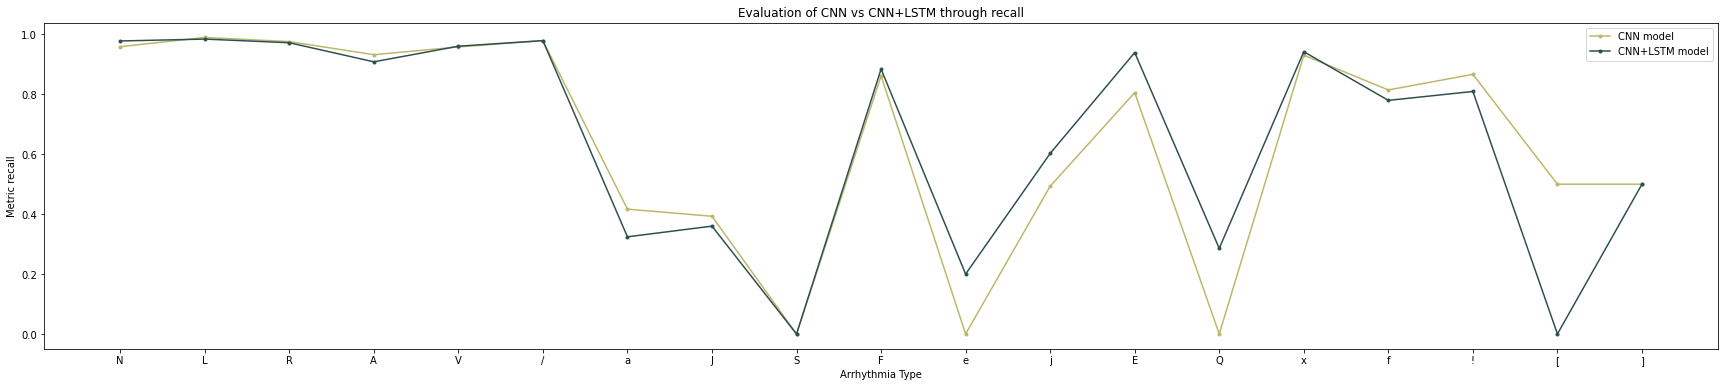

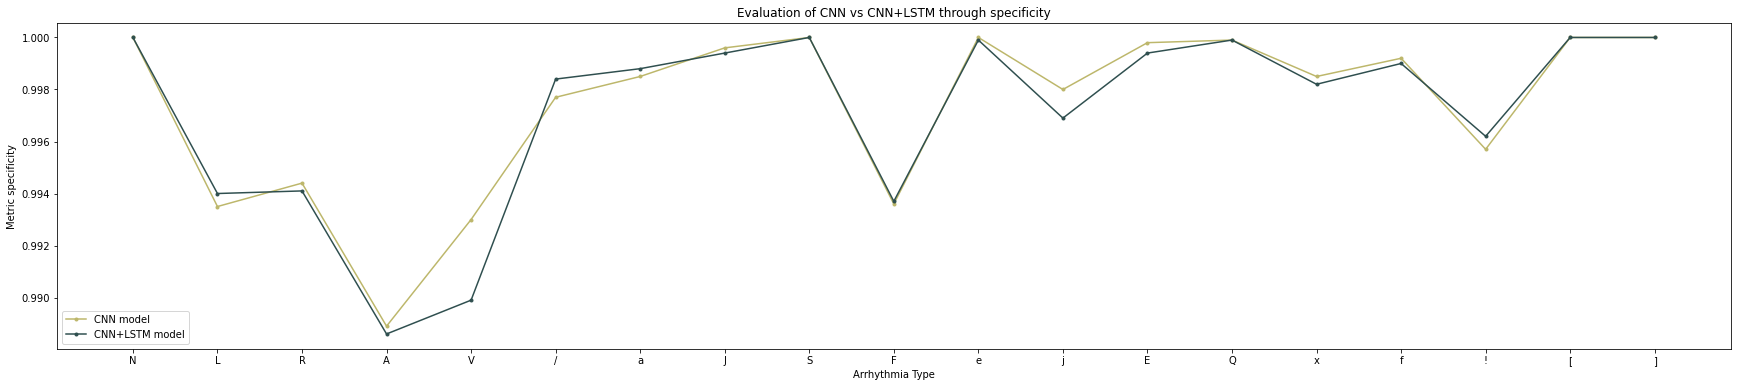

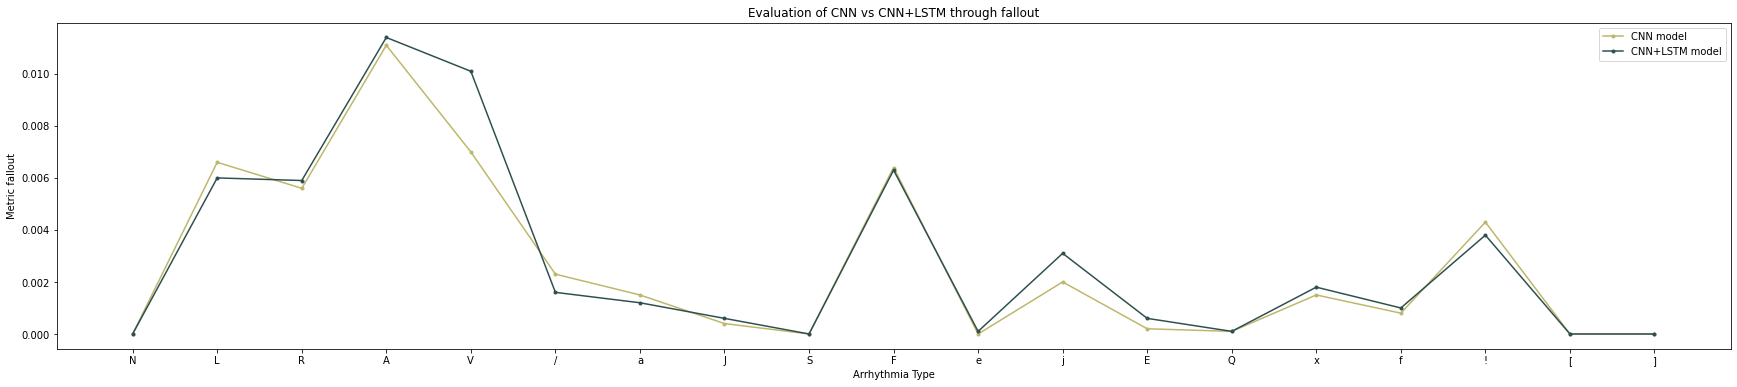

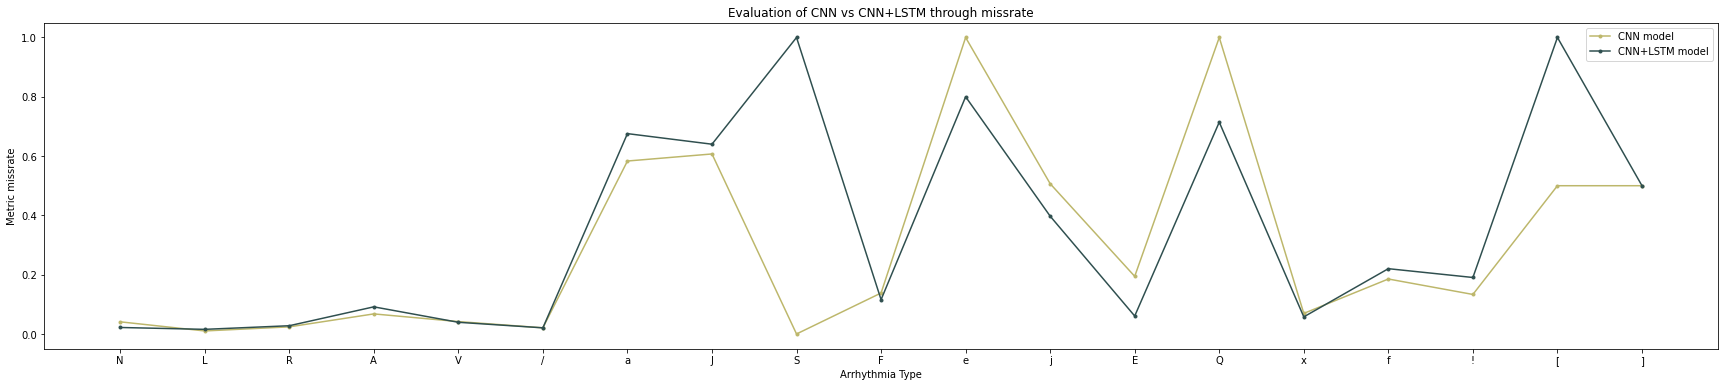

In [ ]:
metrics = ['recall', 'specificity', 'fallout', 'missrate']

for metric in metrics:
    plt.plot(metrics_df[0][metric], label='CNN model', color='darkkhaki', marker='.')
    plt.plot(metrics_df[1][metric], label='CNN+LSTM model', color='darkslategray', marker='.')
    plt.title('Evaluation of CNN vs CNN+LSTM through ' + metric)
    plt.xlabel('Arrhythmia Type')
    plt.ylabel('Metric ' + metric)
    plt.legend()

    pltname = path + 'cnn_vs_cnnlstm_results_eval_metrics_{}.png'.format(metric)
    plt.savefig(pltname)

    plt.show()

## Transfer Learning

https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/

https://keras.io/api/applications/


In [9]:
matrices = np.load(path + 'allclasses_ecm_matrices_3peak.npy')
y = np.loadtxt(path + 'allclasses_signals_classes_3peak', delimiter=',')

# matrices = np.load(path + 'allclasses_ecm_matrices_7peak.npy')
# y = np.loadtxt(path + 'allclasses_signals_classes_7peak', delimiter=',')

# divide dataset 
test_ratio = 0.3
valid_ratio = 0.2

x_train, x_test, y_train, y_test = train_test_split(matrices, y, test_size=test_ratio)

y_train = to_categorical(y_train, num_classes=nclasses)
y_test = to_categorical(y_test, num_classes=nclasses)

print("x_train : ", x_train.shape)
print("x_test  : ", x_test.shape)
print()

print("y_train : ", y_train.shape)
print("y_test  : ", y_test.shape)

x_train :  (24979, 2, 453)
x_test  :  (10706, 2, 453)

y_train :  (24979, 19)
y_test  :  (10706, 19)


### Padding the Heatmaps

In [ ]:
pad_mode= ['edge', 'minimum']

ej shape:  (2, 453)


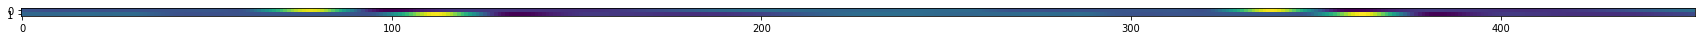

pad_ej shape:  (18, 469)


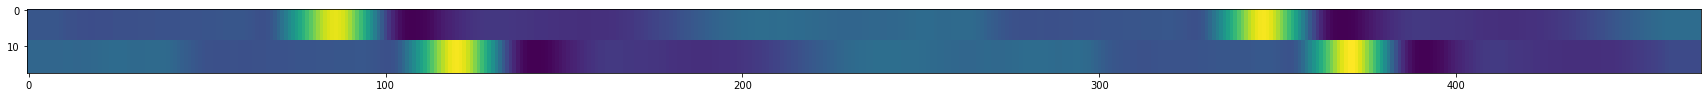

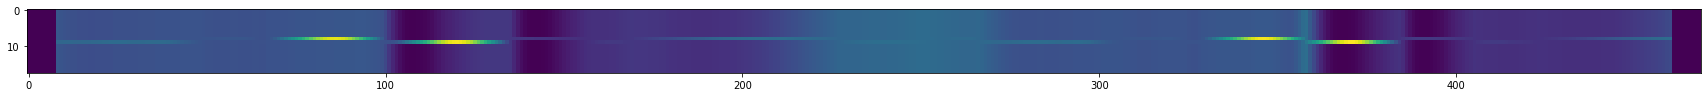

In [ ]:
ej = x_train[0,:,:]
print('ej shape: ', ej.shape)
plt.imshow(ej)
plt.show()

pad_ej = np.pad(ej, pad_width=8, mode='edge')
print('pad_ej shape: ', pad_ej.shape)
plt.imshow(pad_ej)
plt.show()

pad_ej = np.pad(ej, pad_width=8, mode='minimum')
plt.imshow(pad_ej)
plt.show()

#### 3 peaks


In [10]:
NPEAKS = '3PEAKS'

train_matrices = np.zeros( (x_train.shape[0], 18, 469) )  # store all train matrices created 
test_matrices = np.zeros( (x_test.shape[0], 18, 469) )  # store all test matrices created

for i in range(x_train.shape[0]):
    padded_x_train = np.pad(x_train[i,:,:], pad_width=8, mode='edge')
    train_matrices[i, :, :] = padded_x_train

for i in range(x_test.shape[0]):
    padded_x_test = np.pad(x_test[i,:,:], pad_width=8, mode='edge')
    test_matrices[i, :, :] = padded_x_test

train_matrices.shape, test_matrices.shape

((24979, 18, 469), (10706, 18, 469))

In [ ]:
test_matrices[0,0:8,0] #== x_test[0,:,:]

array([1072.9602458, 1072.9602458, 1072.9602458, 1072.9602458,
       1072.9602458, 1072.9602458, 1072.9602458, 1072.9602458])

### Model

In [11]:
inputShape = (0, 0, 0)
reshaped_x_train = 0
reshaped_x_test = 0

if NPEAKS == '3PEAKS':
    reshaped_x_train = train_matrices.reshape( (x_train.shape[0], 42, 67, 3) )
    reshaped_x_test = test_matrices.reshape( (x_test.shape[0], 42, 67, 3) )

elif NPEAKS == '7PEAKS':
    reshaped_x_train = matrices.reshape( (x_train.shape[0], 42, 67, 3) )
    reshaped_x_test = test_matrices.reshape( (x_test.shape[0], 42, 67, 3) )

print(NPEAKS, reshaped_x_train.shape, reshaped_x_test.shape)

3PEAKS (24979, 42, 67, 3) (10706, 42, 67, 3)


#### Densenet

In [ ]:
from keras.applications import densenet # DenseNet121, DenseNet169, DenseNet201
from keras import Input

'''
seems like we are going to have to reshape the inputs so that every heatmap 
is made up of (1, n, 3) (3 channels)
453/151=3
'''
# inputShape = x_train.shape
inputShape = reshaped_x_train.shape[1:]

# load model, include_top-> allows fixed-sized shape input to be changed
model = densenet.DenseNet121(include_top=True, weights=None, input_shape=inputShape, pooling='max', classes=nclasses)

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics= ['accuracy'])

In [ ]:
EPOCHS = 10

filepath = path + "allclasses_densenet121_bestscores_{}_{}.hdf5".format(EPOCHS, NPEAKS)
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

tc = TimingCallback() 
callbacks = [MonitorCallback(), tc]

H = model.fit(reshaped_x_train, y_train, validation_split=0.2, epochs=EPOCHS, verbose=1, callbacks=callbacks)

print('TOTAL TIME: ', sum(tc.logs))

# Save model
model.save(path +'allclasses_densenet121_endoftraining_{}_{}.h5'.format(EPOCHS, NPEAKS))

Epoch 1/10
625/625 [==============================] - 927s 1s/step - loss: 0.0811 - accuracy: 0.7518 - val_loss: 0.2178 - val_accuracy: 0.3229
Saved model with train loss 0.0438 and val loss 0.2178 at epoch 1
Epoch 2/10
625/625 [==============================] - 918s 1s/step - loss: 0.0182 - accuracy: 0.9424 - val_loss: 0.5577 - val_accuracy: 0.2212
Epoch 3/10
625/625 [==============================] - 927s 1s/step - loss: 0.0130 - accuracy: 0.9616 - val_loss: 1.7376 - val_accuracy: 0.0717
Epoch 4/10
625/625 [==============================] - 919s 1s/step - loss: 0.0106 - accuracy: 0.9681 - val_loss: 0.3567 - val_accuracy: 0.2836
Epoch 5/10
625/625 [==============================] - 897s 1s/step - loss: 0.0088 - accuracy: 0.9734 - val_loss: 0.2350 - val_accuracy: 0.4616
Epoch 6/10
625/625 [==============================] - 925s 1s/step - loss: 0.0077 - accuracy: 0.9766 - val_loss: 0.3769 - val_accuracy: 0.2286
Epoch 7/10
625/625 [==============================] - 1001s 2s/step - loss: 

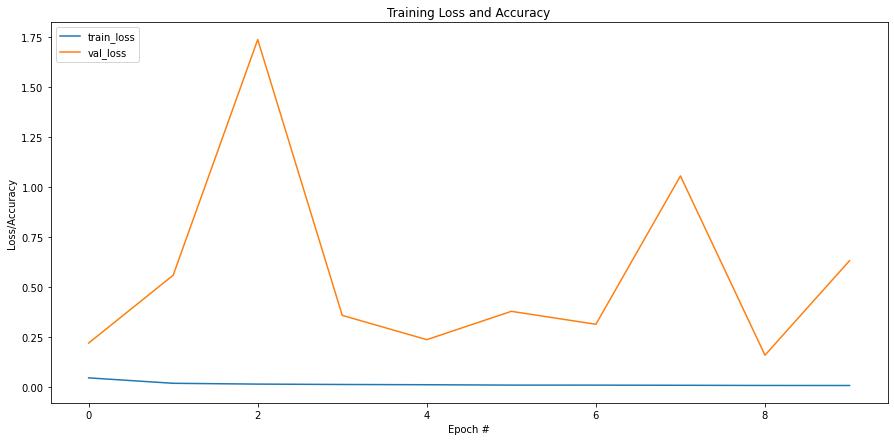

In [ ]:
# plot the training loss and accuracy
plt.figure(figsize=(15,7))

plt.plot(np.arange(0, EPOCHS), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, EPOCHS), H.history["val_loss"], label="val_loss")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")

pltname = path + 'allclasses_densenet121_{}_{}.png'.format(EPOCHS, NPEAKS)
plt.savefig(pltname)

##### Evaluation

In [12]:
EPOCHS = 10
NPEAKS = '3PEAKS'

filepath = path + "allclasses_densenet121_bestscores_{}_{}.hdf5".format(EPOCHS, NPEAKS)

# load the model
model = load_model(filepath)

In [ ]:
print("Evaluate on test data")
results = model.evaluate(reshaped_x_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
335/335 [==============================] - 118s 266ms/step - loss: 0.1579 - accuracy: 0.4796
test loss, test acc: [0.15792801976203918, 0.47963759303092957]


In [52]:
y_pred = model.predict(reshaped_x_test)

y_pred_clean = np.zeros(y_pred.shape)

for i, pred in enumerate(y_pred):
    y_pred_clean[i, np.argmax(pred)] = 1

cms = multilabel_confusion_matrix(y_test, y_pred_clean)

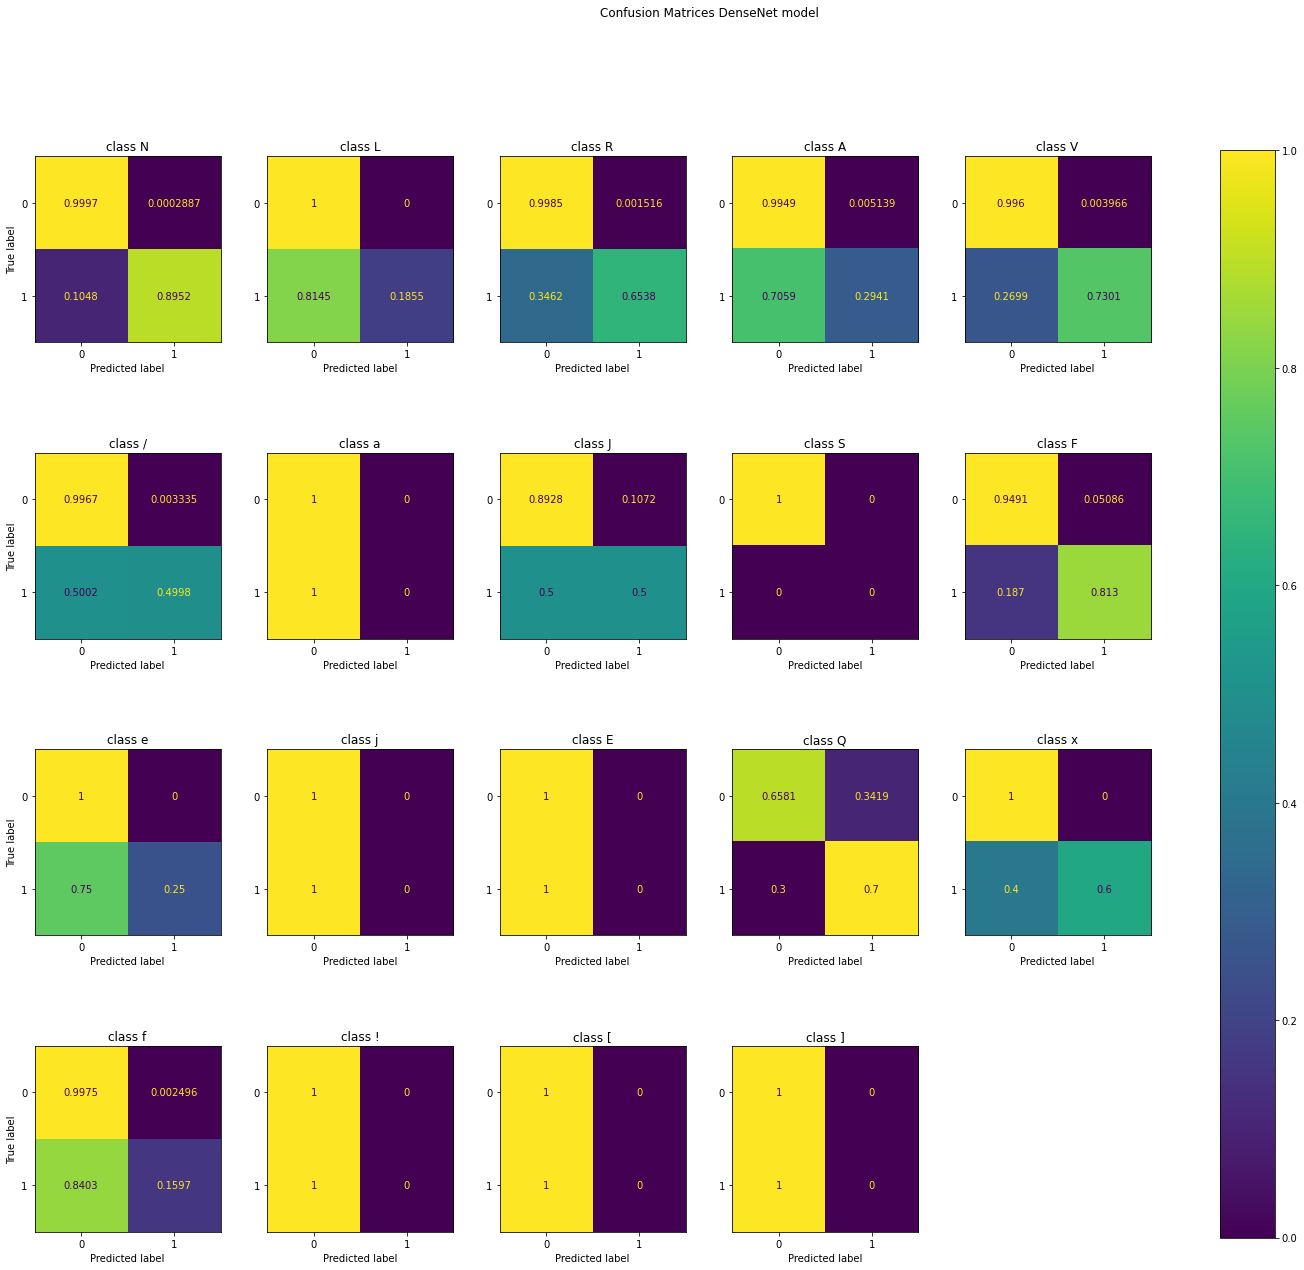

In [55]:
f, axes = plt.subplots(4, 5, figsize=(25, 20))
axes = axes.ravel()
for i in range(nclasses):
    norm_cm = normalize(cms[i], axis=1, norm='l1')
    disp = ConfusionMatrixDisplay(confusion_matrix=norm_cm, display_labels=[0, 1])
    # disp = ConfusionMatrixDisplay(confusion_matrix=cms[i], display_labels=[0, i])
    
    disp.plot(ax=axes[i], values_format='.4g')
    disp.ax_.set_title(f'class '+classes[i])
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.25, hspace=0.5)
f.suptitle('Confusion Matrices DenseNet model')
f.delaxes(ax=axes[-1])
f.colorbar(disp.im_, ax=axes)

pltname = path + 'densenet_model_confmatrices.png'
plt.savefig(pltname)

plt.show()

In [57]:
# cms_densenet = cms
# np.save(path + 'densenet_confmatrix_3peak', cms_densenet)
cms_densenet = np.load(path + 'densenet_confmatrix_3peak.npy')

tn = cms_densenet[:, 0, 0]
tp = cms_densenet[:, 1, 1]
fn = cms_densenet[:, 1, 0]
fp = cms_densenet[:, 0, 1]

densenet_df = pd.DataFrame(data={'TN':tn, 'TP':tp, 'FN':fn, 'FP':fp})
densenet_df.index=classes

#### VGG16

In [ ]:
from keras.applications import vgg16

inputShape = reshaped_x_train.shape[1:]

# load model, include_top-> allows fixed-sized shape input to be changed
model = vgg16.VGG16(include_top=True, weights=None, input_shape=inputShape, pooling='max', classes=nclasses)

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics= ['accuracy'])

In [ ]:
EPOCHS = 10

filepath = path + "allclasses_vgg16_bestscores_{}_{}.hdf5".format(EPOCHS, NPEAKS)
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

tc = TimingCallback() 
callbacks = [MonitorCallback(), tc]

H = model.fit(reshaped_x_train, y_train, validation_split=0.2, epochs=EPOCHS, verbose=1, callbacks=callbacks)

print('TOTAL TIME: ', sum(tc.logs))

# Save model
model.save(path +'allclasses_vgg16_endoftraining_{}_{}.h5'.format(EPOCHS, NPEAKS))

Epoch 1/10
625/625 [==============================] - 2721s 4s/step - loss: 0.4129 - accuracy: 0.2361 - val_loss: 0.0821 - val_accuracy: 0.6934
Saved model with train loss 0.1802 and val loss 0.0821 at epoch 1
Epoch 2/10
625/625 [==============================] - 2675s 4s/step - loss: 0.0696 - accuracy: 0.7617 - val_loss: 0.0437 - val_accuracy: 0.8507
Saved model with train loss 0.0541 and val loss 0.0437 at epoch 2
Epoch 3/10
625/625 [==============================] - 2731s 4s/step - loss: 0.0336 - accuracy: 0.8936 - val_loss: 0.0238 - val_accuracy: 0.9229
Saved model with train loss 0.0310 and val loss 0.0238 at epoch 3
Epoch 4/10
625/625 [==============================] - 2634s 4s/step - loss: 0.0264 - accuracy: 0.9149 - val_loss: 0.0259 - val_accuracy: 0.9141
Epoch 5/10
625/625 [==============================] - 2630s 4s/step - loss: 0.0217 - accuracy: 0.9304 - val_loss: 0.0192 - val_accuracy: 0.9410
Saved model with train loss 0.0225 and val loss 0.0192 at epoch 5
Epoch 6/10
625/6

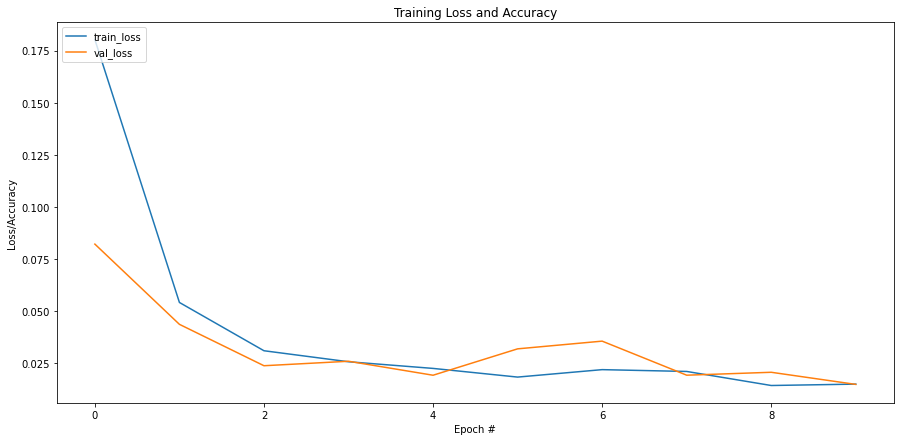

In [ ]:
# plot the training loss and accuracy
plt.figure(figsize=(15,7))

plt.plot(np.arange(0, EPOCHS), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, EPOCHS), H.history["val_loss"], label="val_loss")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")

pltname = path + 'allclasses_vgg16_{}_{}.png'.format(EPOCHS, NPEAKS)
plt.savefig(pltname)

##### Evaluation

In [58]:
EPOCHS = 10
NPEAKS = '3PEAKS'

filepath = path + "allclasses_vgg16_bestscores_{}_{}.hdf5".format(EPOCHS, NPEAKS)

# load the model
model = load_model(filepath)

In [ ]:
print("Evaluate on test data")
results = model.evaluate(reshaped_x_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
335/335 [==============================] - 203s 605ms/step - loss: 0.0135 - accuracy: 0.9583
test loss, test acc: [0.013539995066821575, 0.958341121673584]


In [59]:
y_pred = model.predict(reshaped_x_test)

y_pred_clean = np.zeros(y_pred.shape)

for i, pred in enumerate(y_pred):
    y_pred_clean[i, np.argmax(pred)] = 1

cms = multilabel_confusion_matrix(y_test, y_pred_clean)

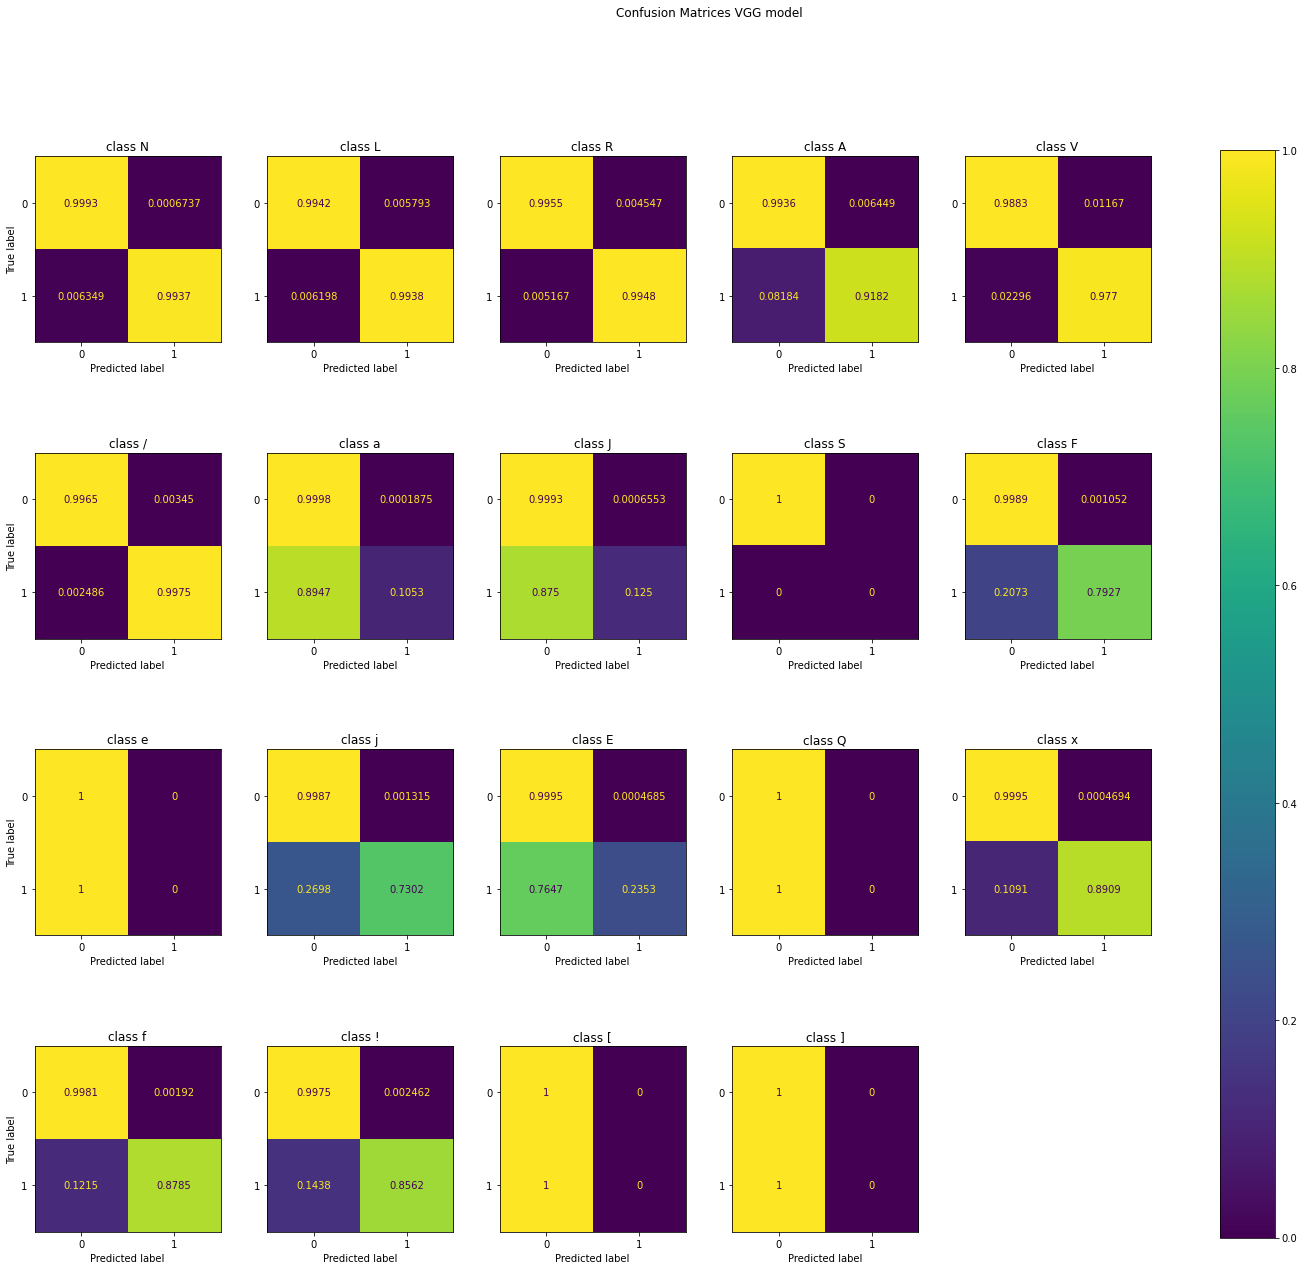

In [60]:
f, axes = plt.subplots(4, 5, figsize=(25, 20))
axes = axes.ravel()
for i in range(nclasses):
    norm_cm = normalize(cms[i], axis=1, norm='l1')
    disp = ConfusionMatrixDisplay(confusion_matrix=norm_cm, display_labels=[0, 1])
    # disp = ConfusionMatrixDisplay(confusion_matrix=cms[i], display_labels=[0, i])
    
    disp.plot(ax=axes[i], values_format='.4g')
    disp.ax_.set_title(f'class '+classes[i])
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.25, hspace=0.5)
f.suptitle('Confusion Matrices VGG model')
f.delaxes(ax=axes[-1])
f.colorbar(disp.im_, ax=axes)

pltname = path + 'vgg_model_confmatrices.png'
plt.savefig(pltname)

plt.show()

In [63]:
cms_vgg = cms
np.save(path + 'vgg_confmatrix_3peak', cms_vgg)
# cms_cnn = np.load(path + 'densenet_confmatrix_3peak.npy')

tn = cms_vgg[:, 0, 0]
tp = cms_vgg[:, 1, 1]
fn = cms_vgg[:, 1, 0]
fp = cms_vgg[:, 0, 1]

vgg_df = pd.DataFrame(data={'TN':tn, 'TP':tp, 'FN':fn, 'FP':fp})
vgg_df.index=classes
results_dfs = [densenet_df, vgg_df]

## DenseNet vs VGG eval

In [64]:
results_dfs[0]

,TN,TP,FN,FP
N,10388,282,33,3
L,8286,449,1971,0
R,8564,1392,737,13
A,9873,230,552,51
V,8538,1558,576,34
/,8666,1005,1006,29
a,10668,0,38,0
J,9537,12,12,1145
S,10706,0,0,0
F,9928,200,46,532


In [65]:
metrics_df = []

for r in results_dfs:
    recall = r['TP'] / (r['TP']+r['FN'])
    specif = r['TN'] / (r['TN'] + r['FP'])
    fall_out =  r['FP'] / (fp + r['TN'])
    miss_rate = r['FN'] / (r['FN'] + r['TP'])
    
    df = pd.DataFrame(data={'recall': recall,
                            'specificity':specif,
                            'fallout': fall_out,
                            'missrate': miss_rate})
    df = df.fillna(0)
    df = df.round(decimals=4)

    metrics_df.append(df)
    
metrics_df[0]

,recall,specificity,fallout,missrate
N,0.8952,0.9997,0.0003,0.1048
L,0.1855,1.0000,0.0000,0.8145
R,0.6538,0.9985,0.0015,0.3462
A,0.2941,0.9949,0.0051,0.7059
V,0.7301,0.9960,0.0039,0.2699
/,0.4998,0.9967,0.0033,0.5002
a,0.0000,1.0000,0.0000,1.0000
J,0.5000,0.8928,0.1200,0.5000
S,0.0000,1.0000,0.0000,0.0000
F,0.8130,0.9491,0.0535,0.1870


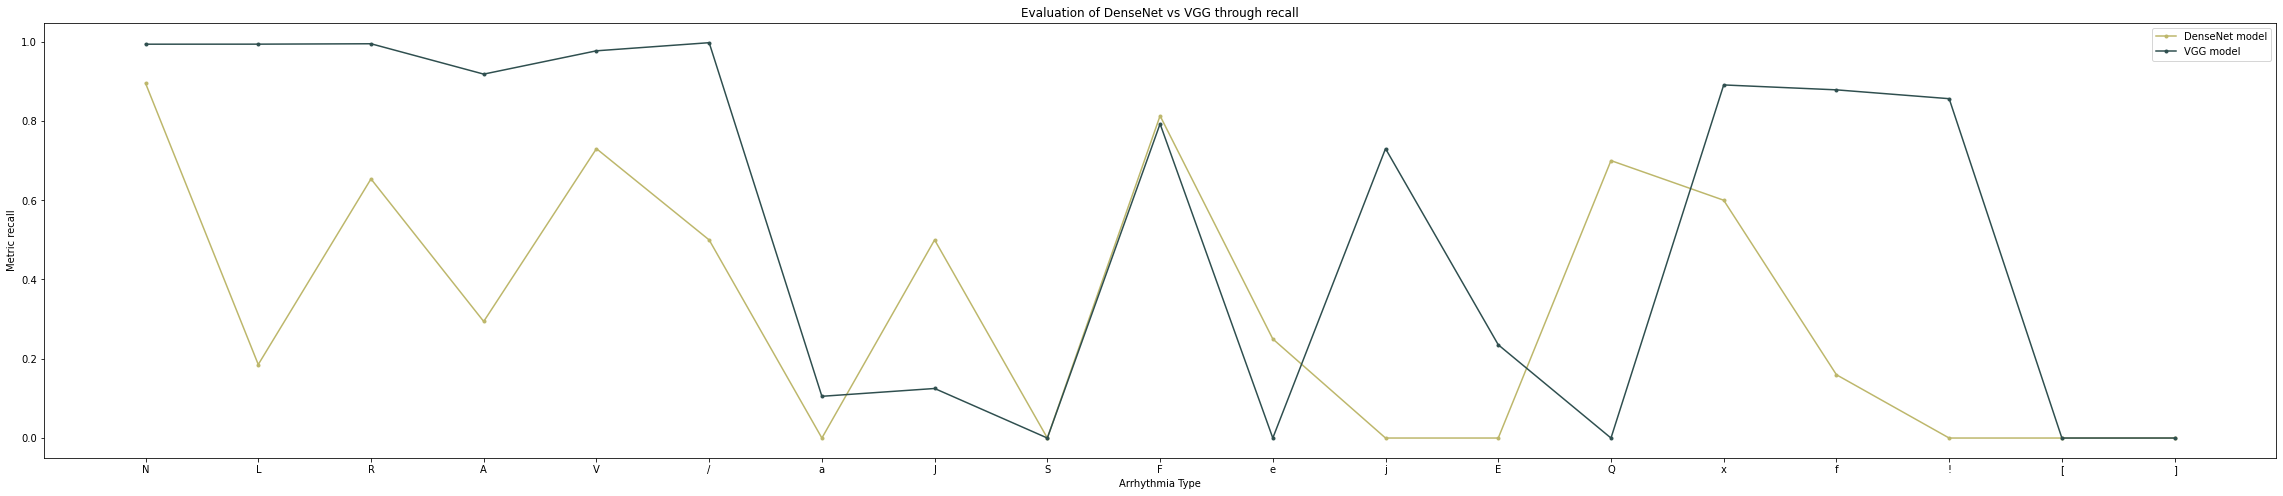

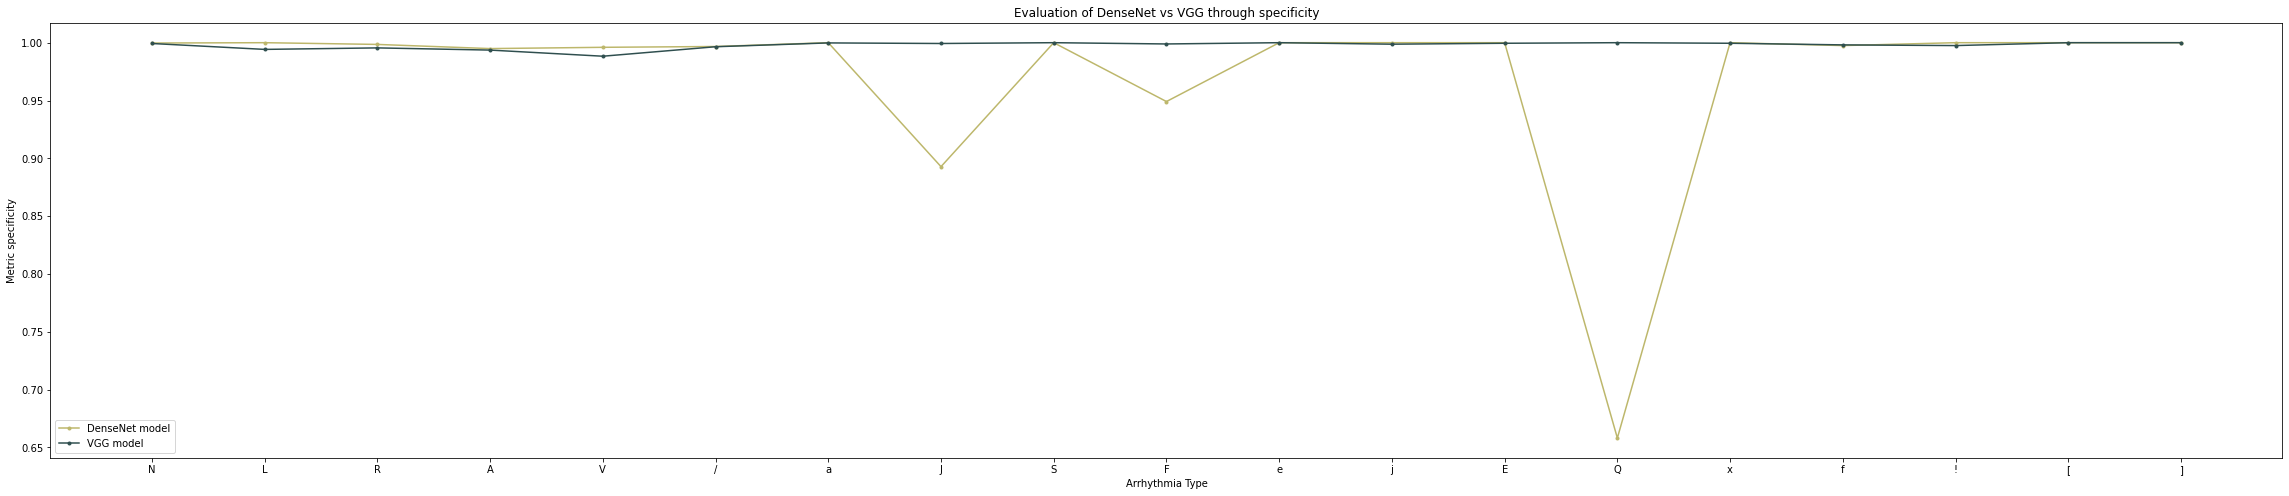

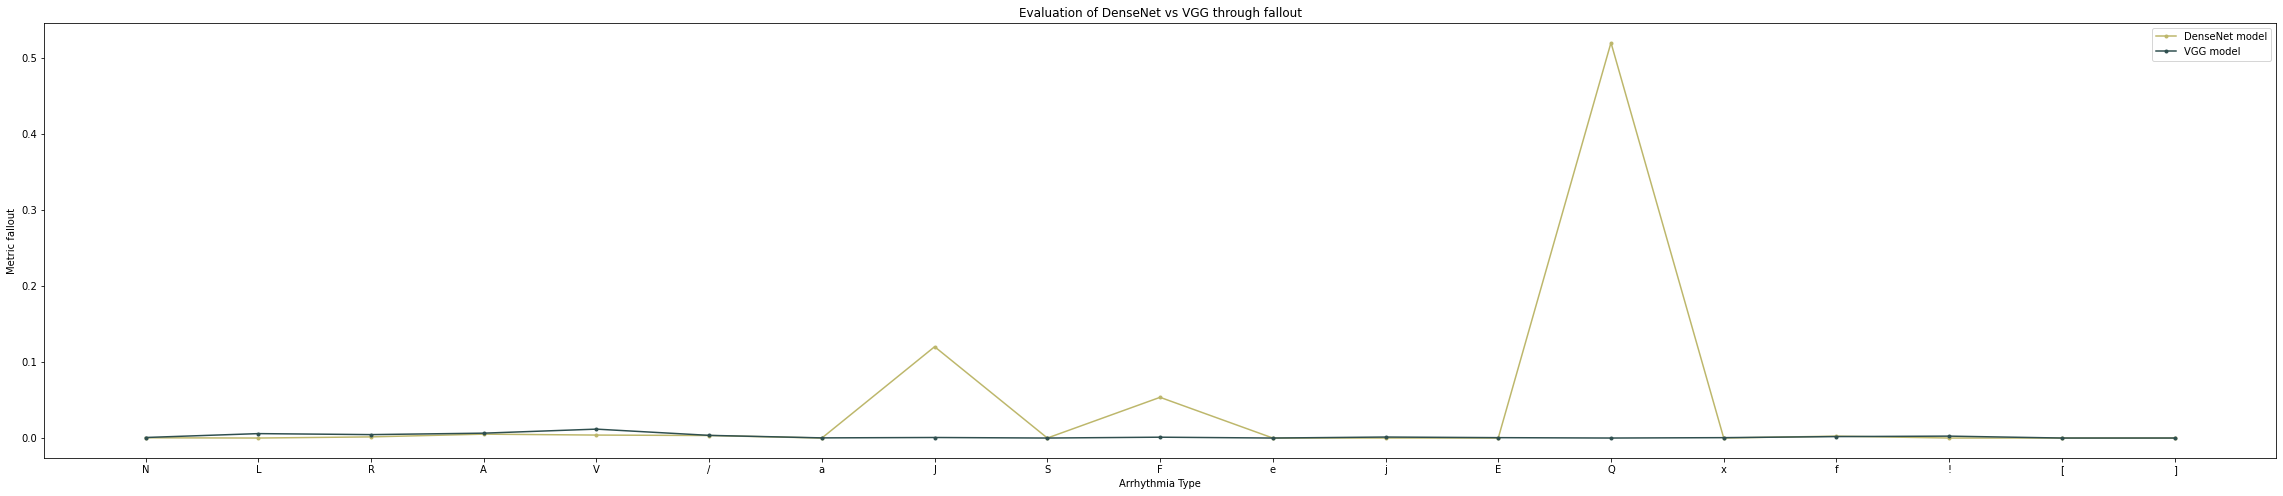

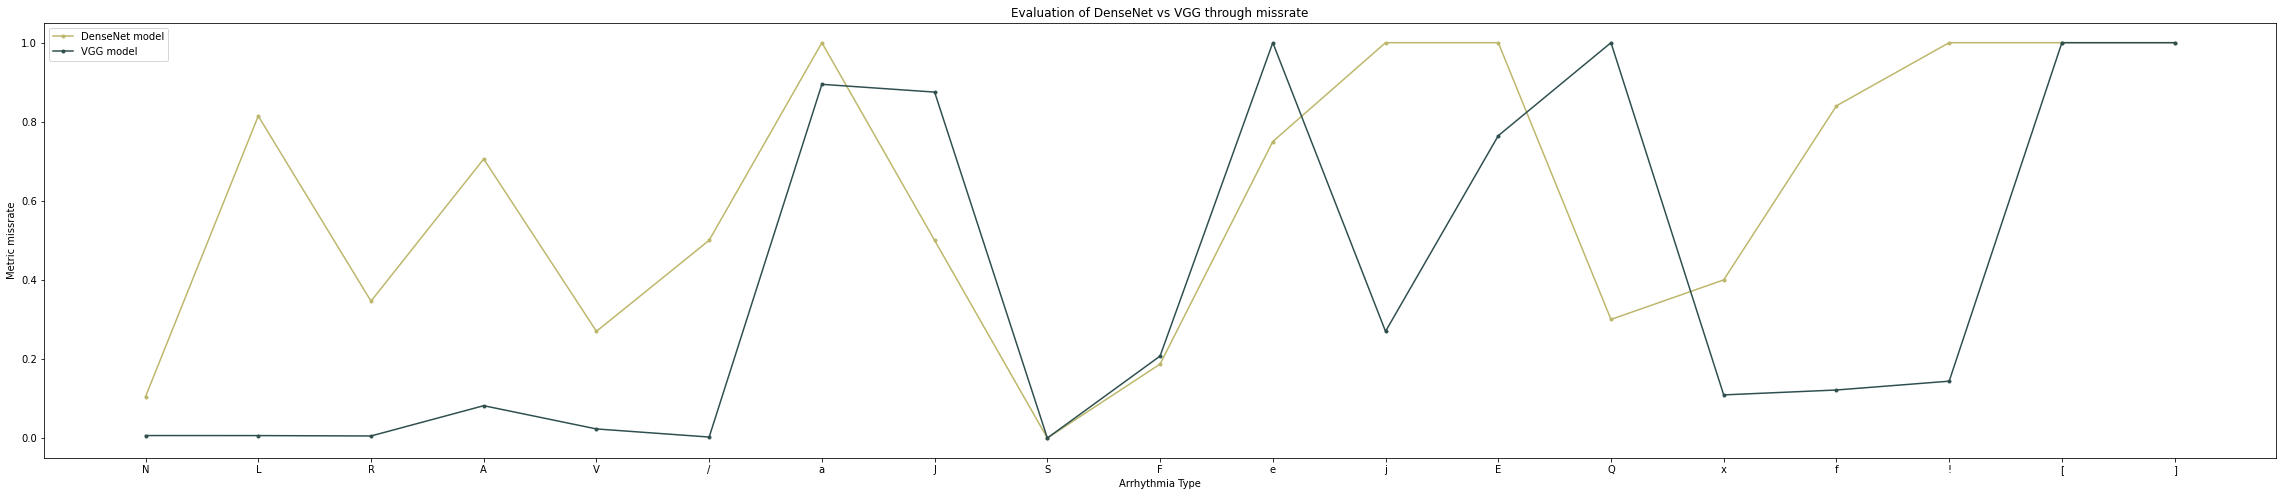

In [72]:
plt.rcParams["figure.figsize"] = (40,8)
metrics = ['recall', 'specificity', 'fallout', 'missrate']

for metric in metrics:
    plt.plot(metrics_df[0][metric], label='DenseNet model', color='darkkhaki', marker='.')
    plt.plot(metrics_df[1][metric], label='VGG model', color='darkslategray', marker='.')
    plt.title('Evaluation of DenseNet vs VGG through ' + metric)
    plt.xlabel('Arrhythmia Type')
    plt.ylabel('Metric ' + metric)
    plt.legend()

    pltname = path + 'densenet_vs_vgg_results_eval_metrics_{}.png'.format(metric)
    plt.savefig(pltname)

    plt.show()